!pip install pandas numpy matplotlib seaborn plotly pydot graphviz scikit-learn tensorflow keras keras-vis tf_keras_vis tf-explain xgboost shap skimpy streamlit

Load Libraries

In [1]:
# Data Handling and Manipulation
import pandas as pd
import numpy as np
import datetime
import shap

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

# Machine Learning
# Model Selection and Evaluation
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score

# Preprocessing and Feature Engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Model Explanation and Interpretation
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical, plot_model
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_explain.core.integrated_gradients import IntegratedGradients

# Utility Libraries
import skimpy
import streamlit as st
from IPython.display import Image, display

Import Data

In [2]:
loan = pd.read_csv("loan_train.csv")
loan.columns = loan.columns.str.lower()  # clean column names
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [3]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501.0,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430.0,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1076863.0,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1069639.0,1304742.0,7000.0,7000.0,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,Sep-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1072053.0,1288686.0,3000.0,3000.0,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


Feature Engineering

In [4]:
# take a look at date format
loan[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,Dec-2011,Jan-1985,Jan-2015,Sep-2016
1,Dec-2011,Apr-1999,Apr-2013,Sep-2016
2,Dec-2011,Feb-1996,Jan-2015,Apr-2016
3,Dec-2011,Jul-2005,May-2016,Sep-2016
4,Dec-2011,Jan-2007,Jan-2015,Dec-2014


In [5]:
# Specify a format on dates
loan['issue_d_year'] = pd.to_datetime(loan['issue_d'], format='%b-%Y').dt.year
loan['earliest_cr_line_year'] = pd.to_datetime(loan['earliest_cr_line'], format='%b-%Y').dt.year
loan['last_pymnt_d_year'] = pd.to_datetime(loan['last_pymnt_d'], format='%b-%Y').dt.year
loan['last_credit_pull_d_year'] = pd.to_datetime(loan['last_credit_pull_d'], format='%b-%Y').dt.year

# Create new features based on dates
current_year = pd.to_datetime('today').year
loan['issue_d_year'] = current_year - loan['issue_d_year']
loan['earliest_cr_line_year'] = current_year - loan['earliest_cr_line_year']
loan['last_pymnt_d_year'] = current_year - loan['last_pymnt_d_year']
loan['last_credit_pull_d_year'] = current_year - loan['last_credit_pull_d_year']

# Drop original date columns
loan.drop(columns=['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], inplace=True)

In [6]:
# Summary statistics
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,issue_d_year,earliest_cr_line_year,last_pymnt_d_year,last_credit_pull_d_year
0,1077501.0,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,14.0,40.0,10.0,9.0
1,1077430.0,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,14.0,26.0,12.0,9.0
2,1076863.0,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,14.0,29.0,10.0,9.0
3,1069639.0,1304742.0,7000.0,7000.0,7000.0,60 months,15.96%,170.08,C,C5,...,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,14.0,20.0,9.0,9.0
4,1072053.0,1288686.0,3000.0,3000.0,3000.0,36 months,18.64%,109.43,E,E1,...,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,14.0,18.0,10.0,11.0


Data Cleaning

In [7]:
# Calculate the missing value ratio for each column
missing_ratio = loan.isnull().mean()

# Identify columns with more than 20% missing values
dropped_columns = missing_ratio[missing_ratio > 0.2].index.tolist()

# Print the names of columns that will be dropped
print("Dropped columns:", dropped_columns)

# Drop those columns from the DataFrame
loan = loan.drop(columns=dropped_columns)

Dropped columns: ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d']


In [8]:
# Data Cleaning
loan['int_rate'] = loan['int_rate'].str.replace('%', '').astype(float) / 100
loan['revol_util'] = loan['revol_util'].str.replace('%', '').astype(float) / 100

Explanatory Data Analysis (EDA)

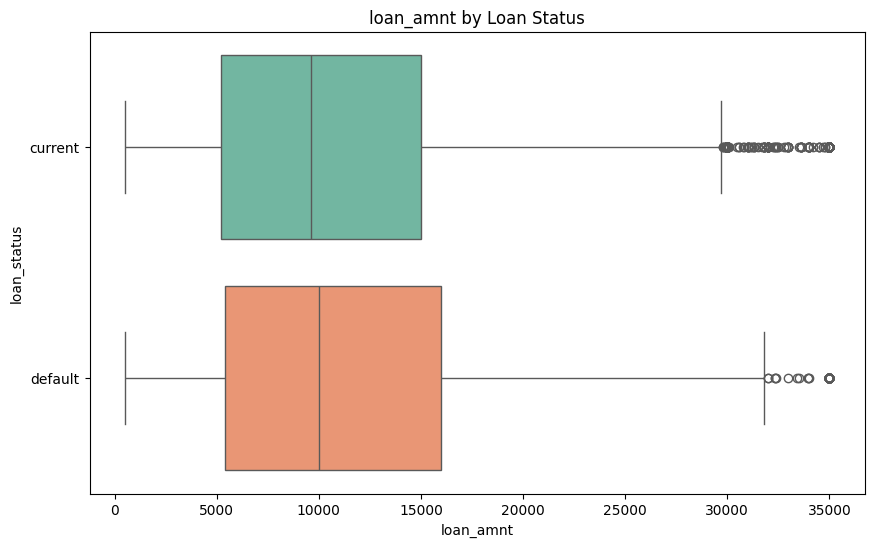

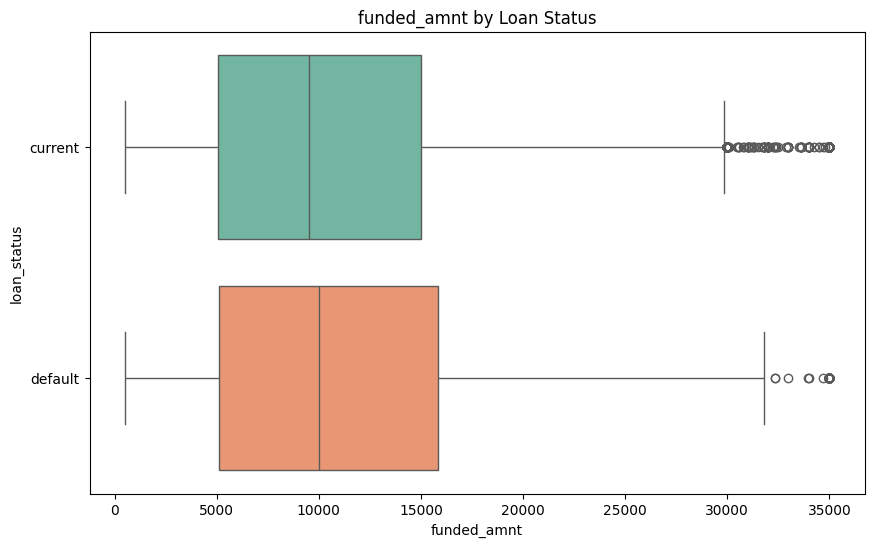

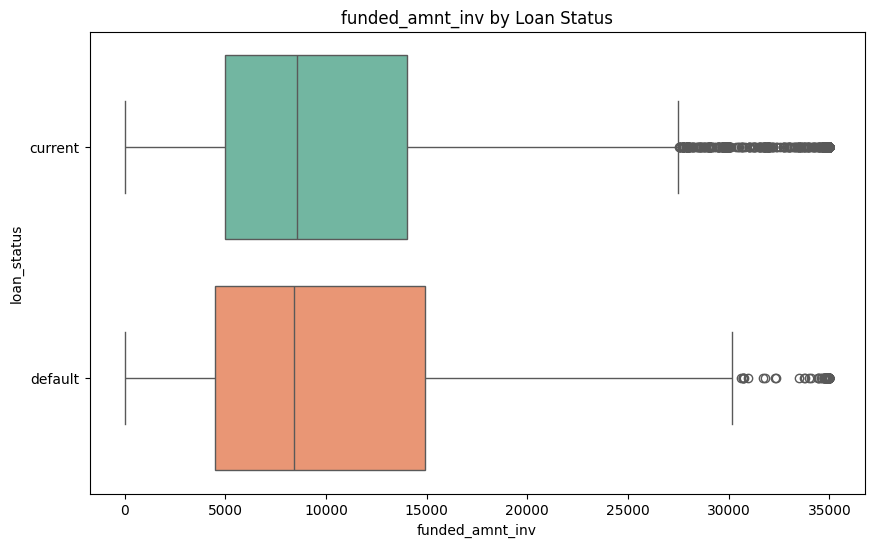

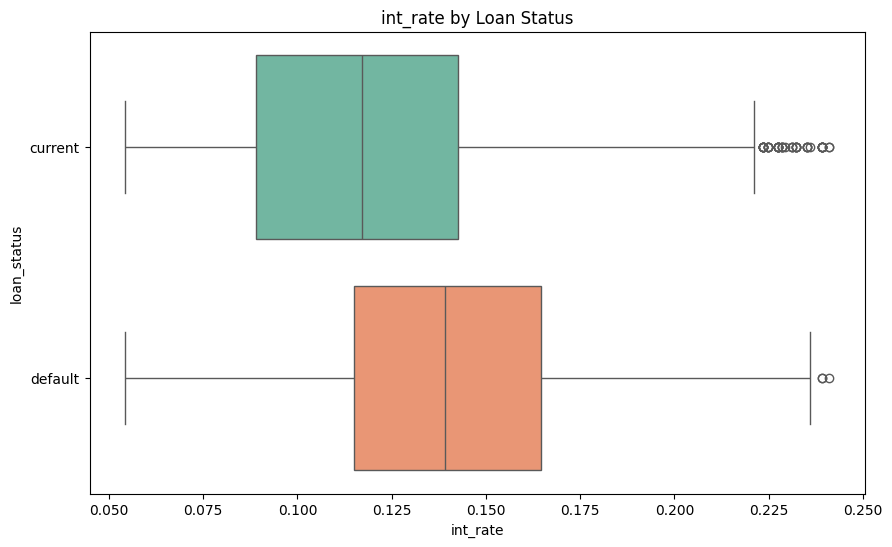

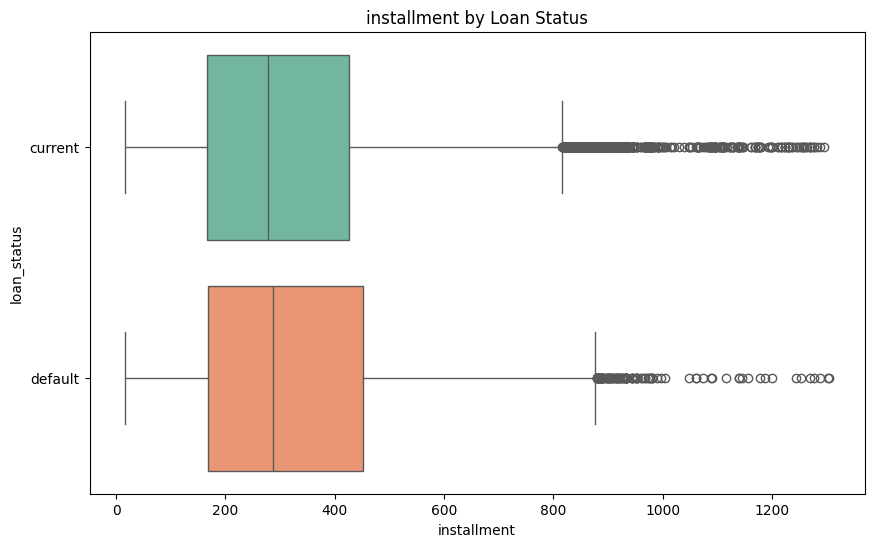

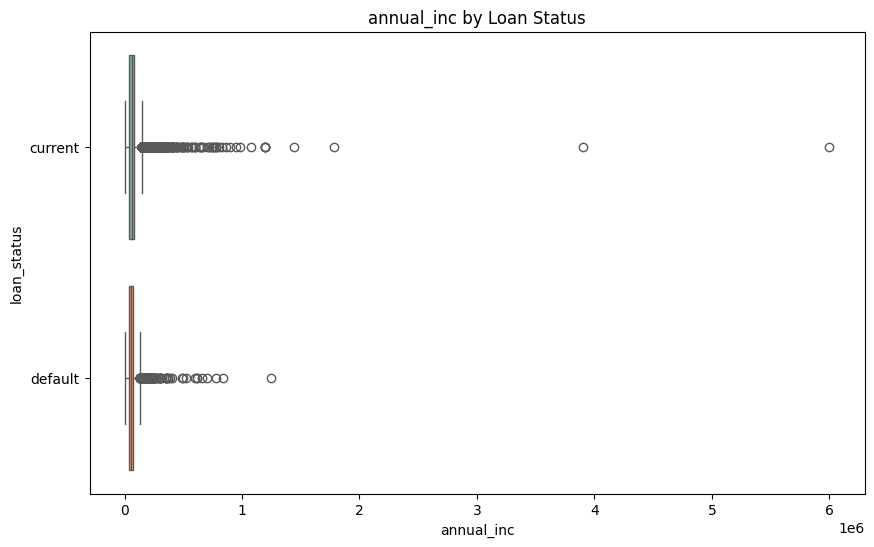

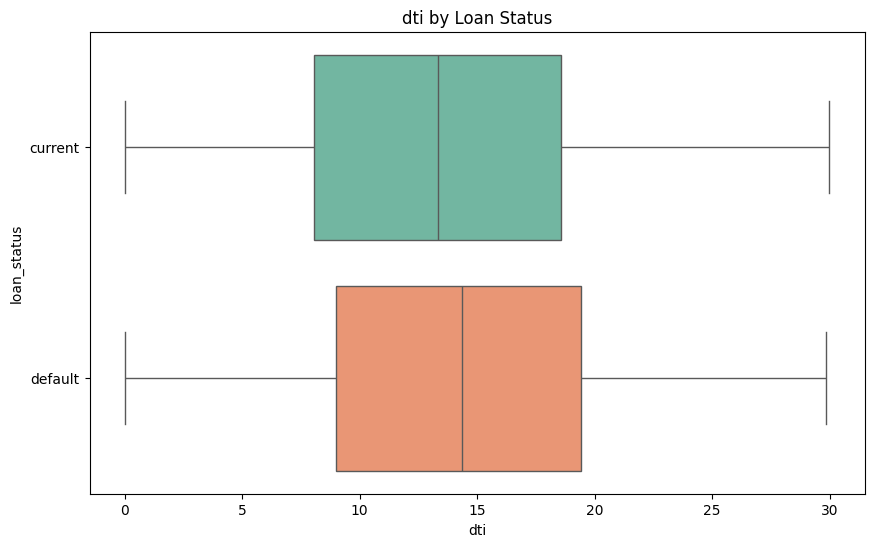

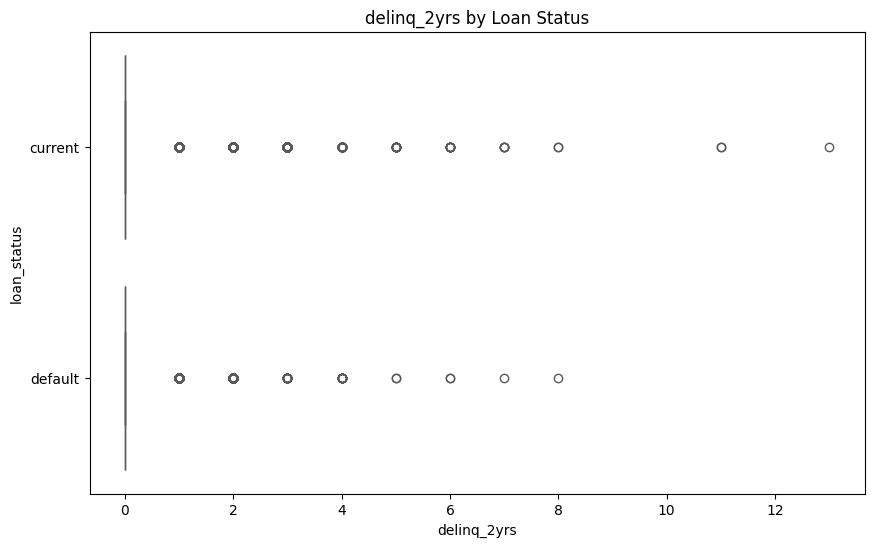

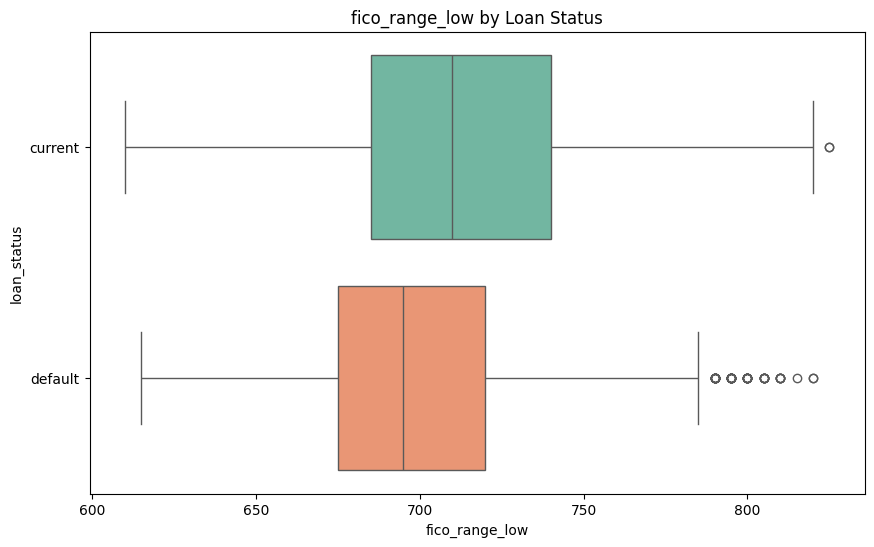

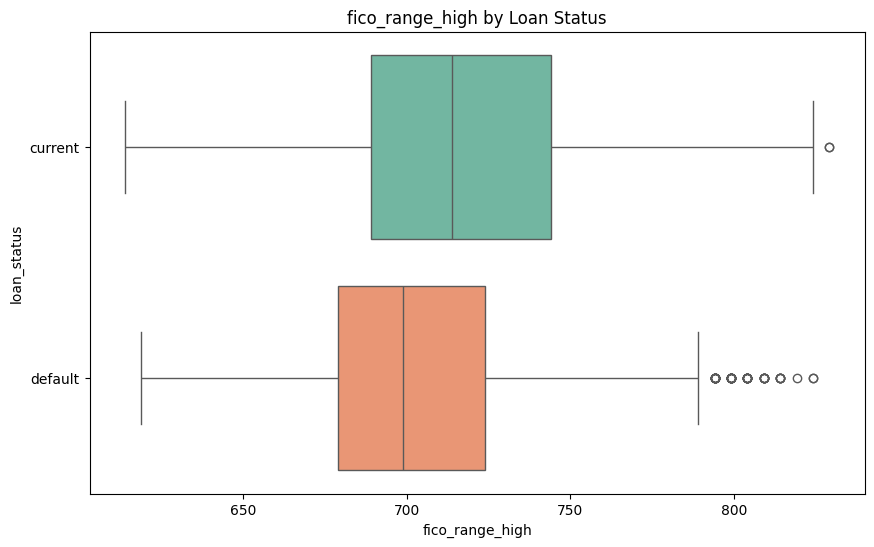

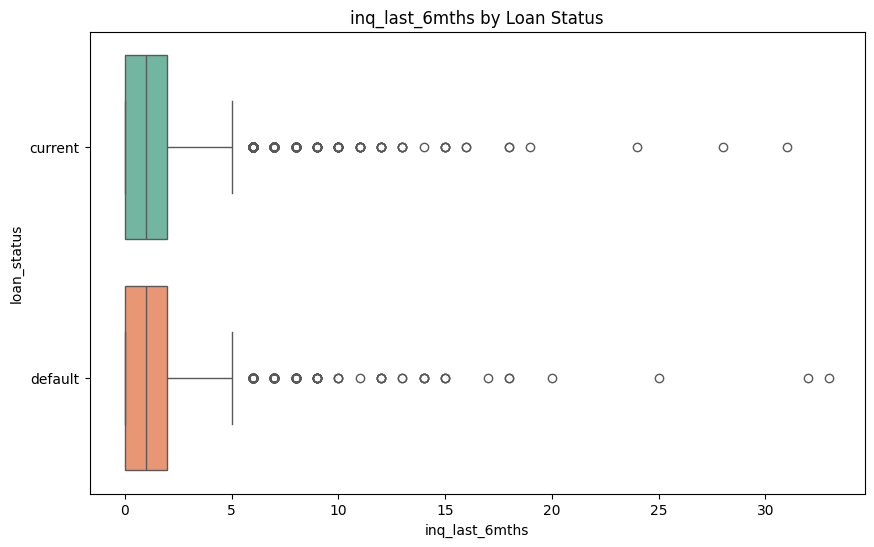

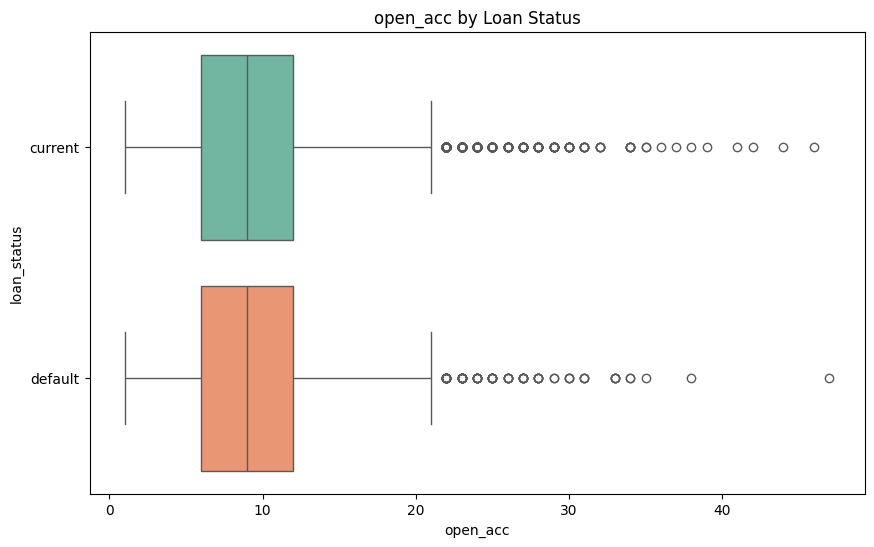

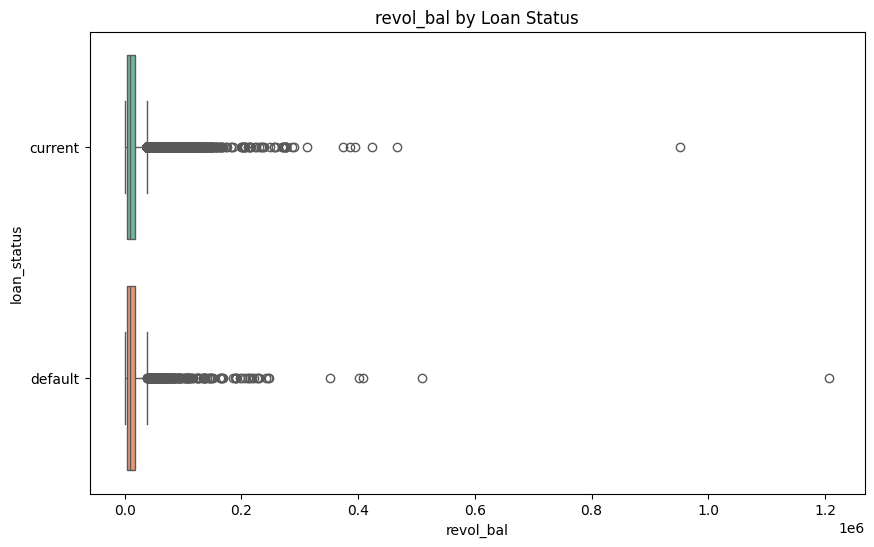

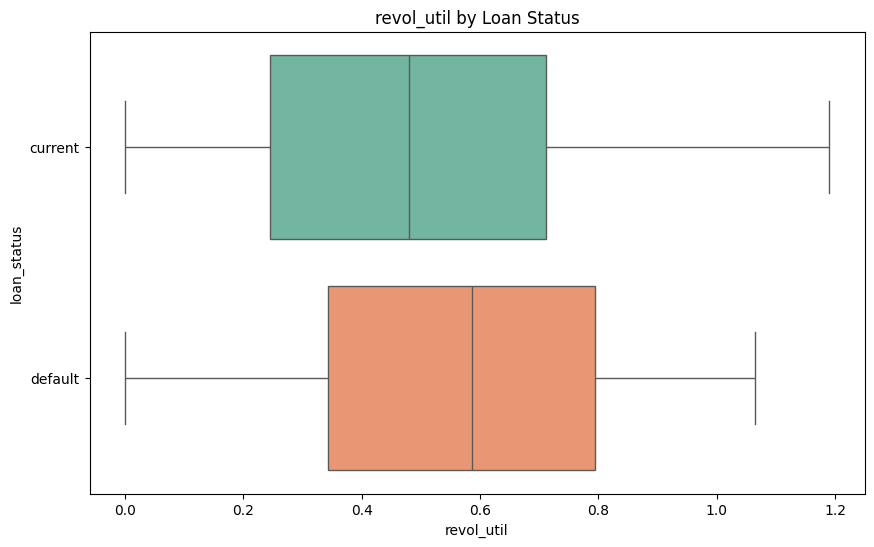

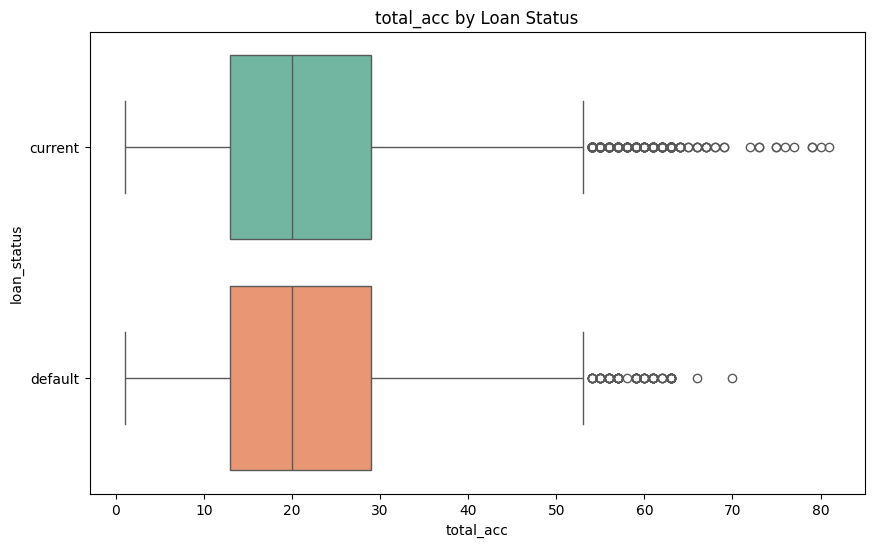

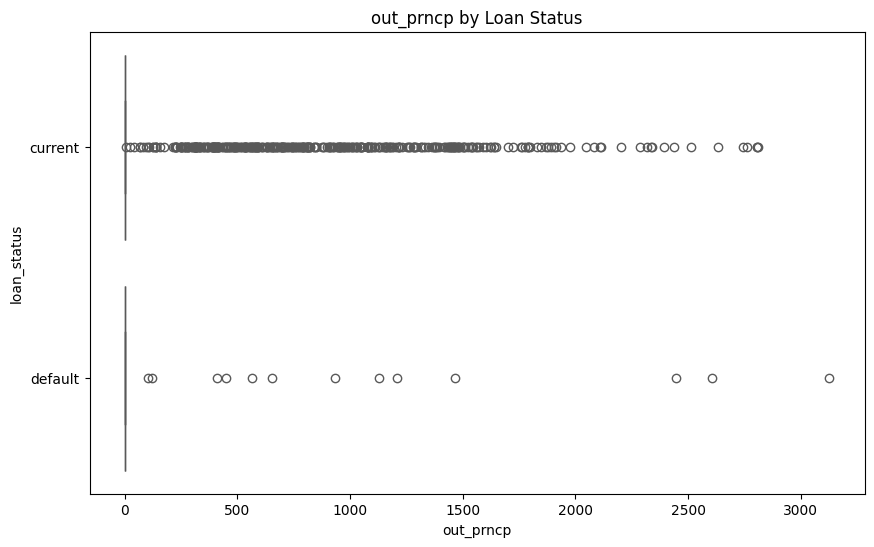

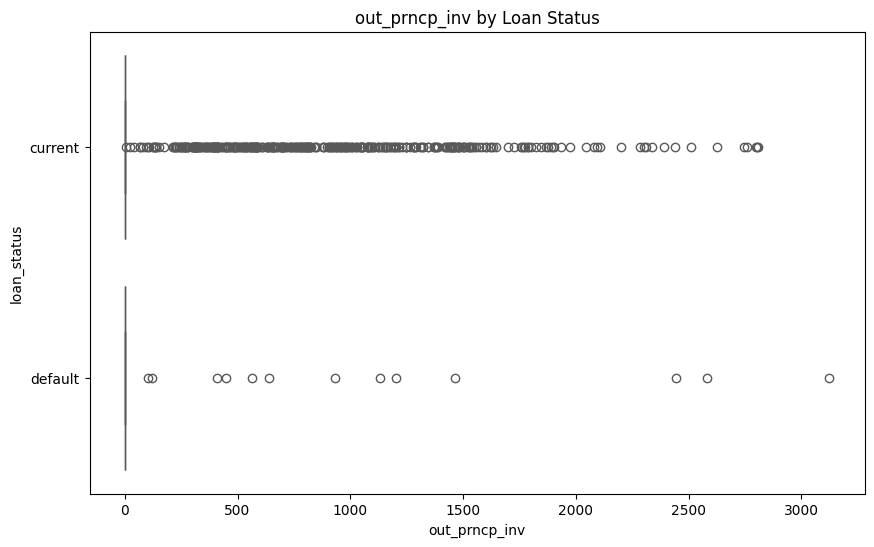

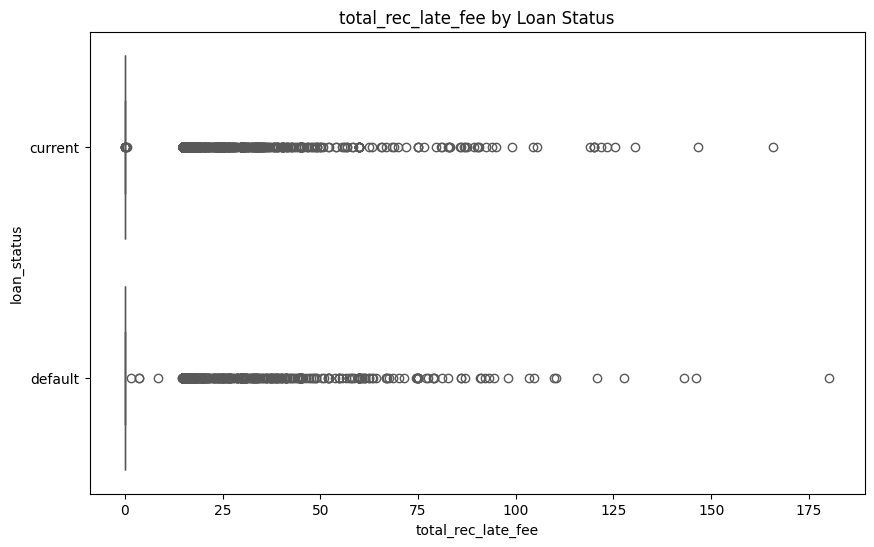

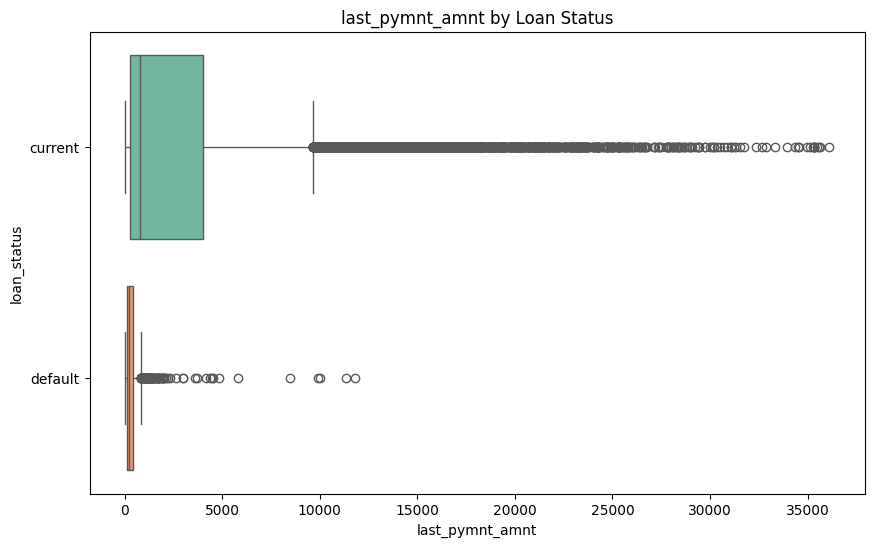

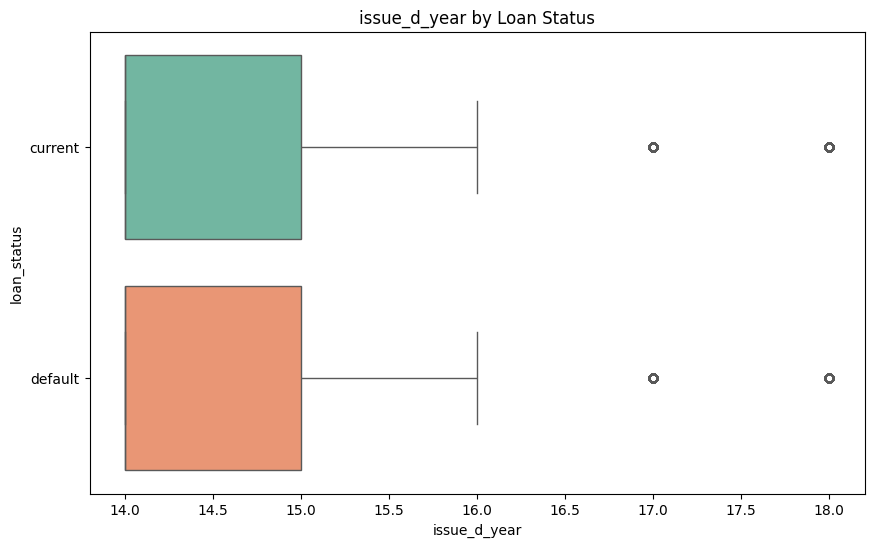

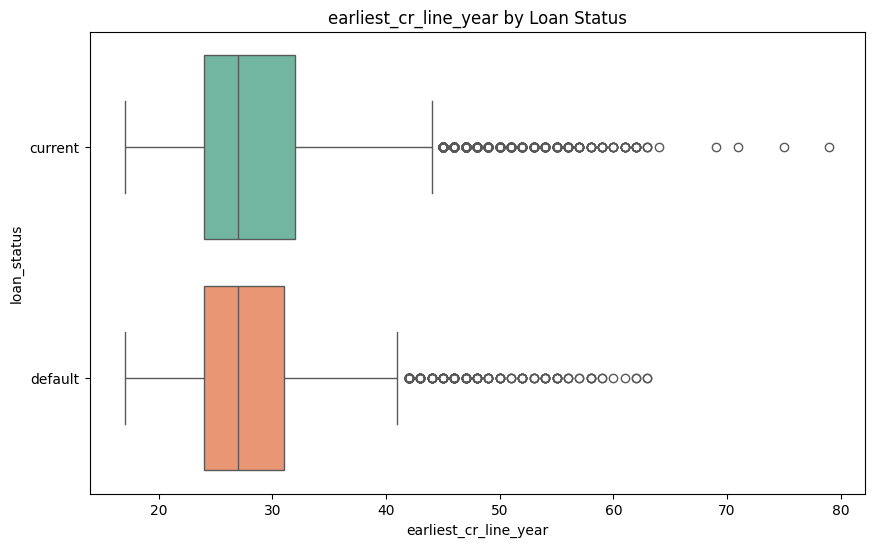

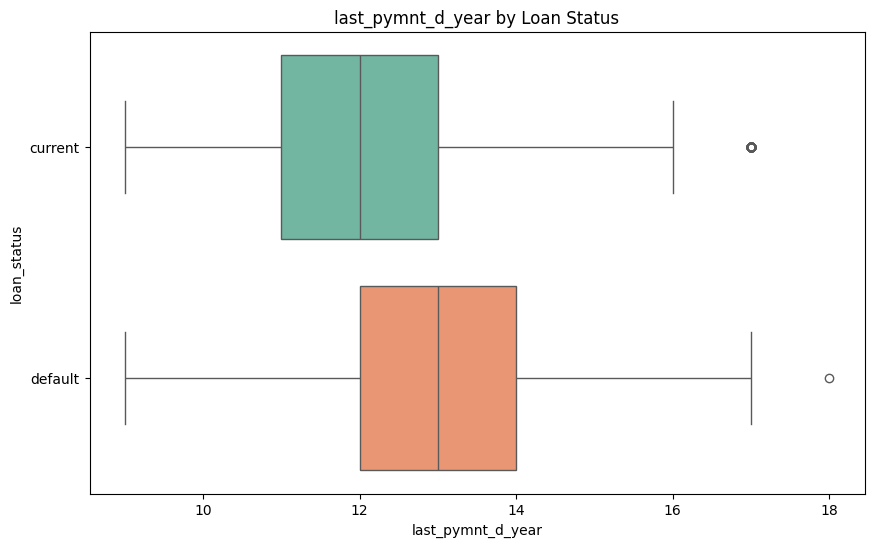

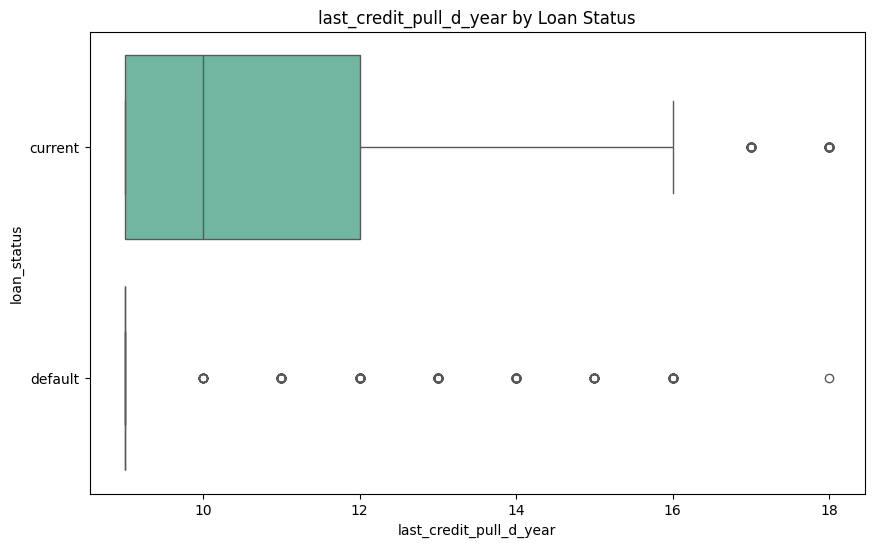

In [9]:
# Boxplot function for numeric variables
def plot_box(m):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=m, y='loan_status', data=loan, hue='loan_status', palette='Set2', legend=False)
    plt.title(f'{m} by Loan Status')
    plt.show()

# Numeric columns to plot
numerics = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 
            'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'revol_bal', 
            'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_amnt', 
            'issue_d_year', 'earliest_cr_line_year', 'last_pymnt_d_year', 'last_credit_pull_d_year']

# Plot for each numeric column
for col in numerics:
    plot_box(col)

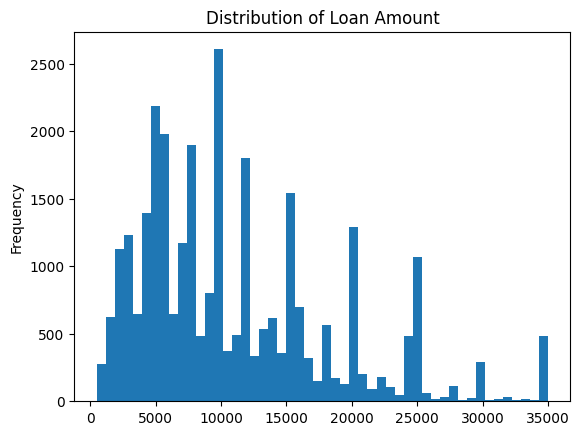

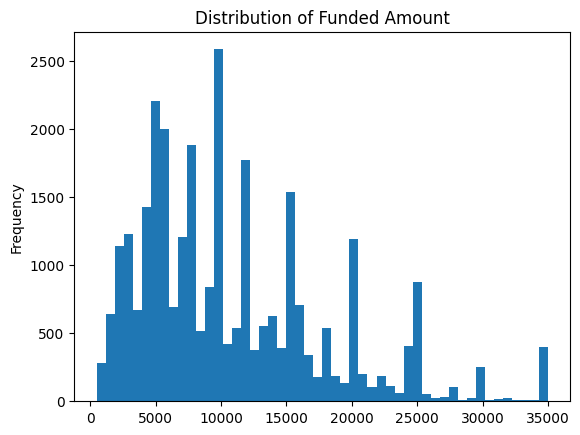

In [10]:
# Explore the distributions of some numeric variables
loan['loan_amnt'].plot(kind='hist', bins=50, title='Distribution of Loan Amount')
plt.show()

loan['funded_amnt'].plot(kind='hist', bins=50, title='Distribution of Funded Amount')
plt.show()

In [11]:
# Remove outliers based on specific columns
loan = loan[(loan['annual_inc'] < 500000) & (loan['revol_bal'] < 300000)]

In [12]:
# Convert character columns to categorical data
char_cols = ['pub_rec', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 
             'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
loan[char_cols] = loan[char_cols].astype(str)

In [13]:
# First, define the function for the Stacked Horizontal Bar Plot
def plot_stacked_bar(col):
    # Create a cross-tabulation to count the occurrences of categories, split by loan_status
    cross_tab = pd.crosstab(loan[col], loan['loan_status'], normalize='index') * 100
    
    # Plot the Stacked Horizontal Bar Chart
    ax = cross_tab.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Set2')
    
    # Customize the plot with labels and title
    ax.set_title(f'Stacked Horizontal Bar Plot of {col} by Loan Status')
    ax.set_xlabel('Percentage (%)')
    ax.set_ylabel(col)
    plt.xticks(rotation=45)
    plt.show()

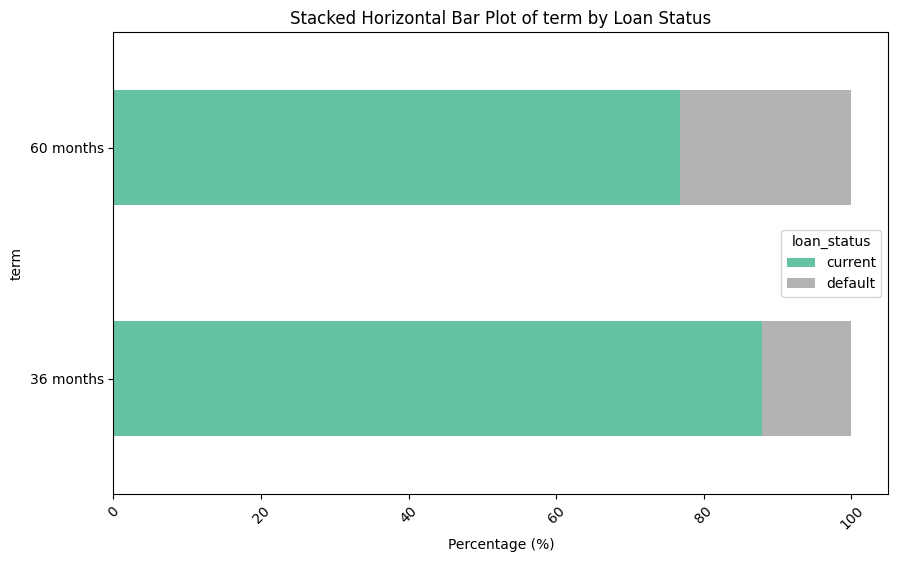

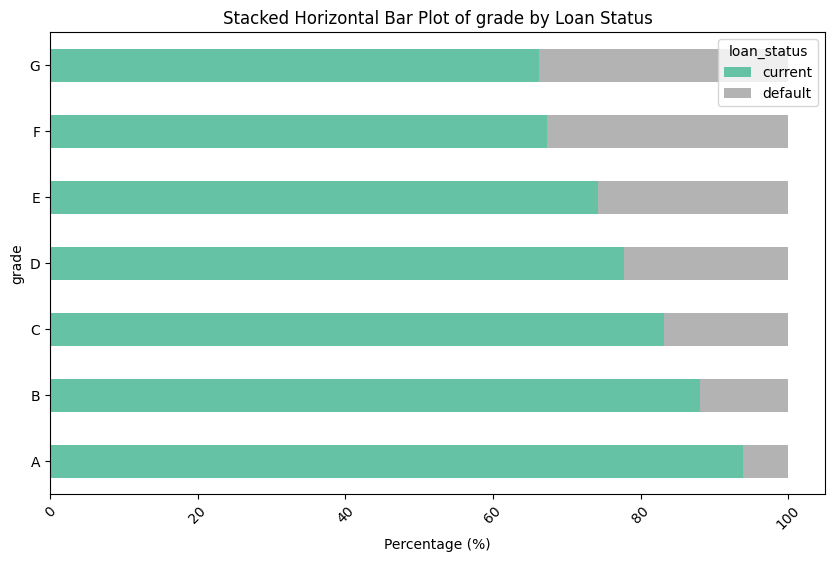

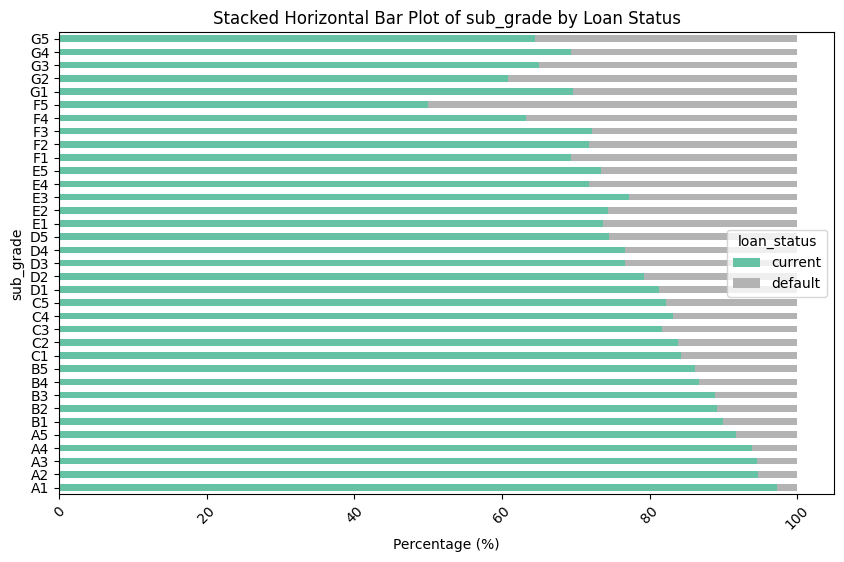

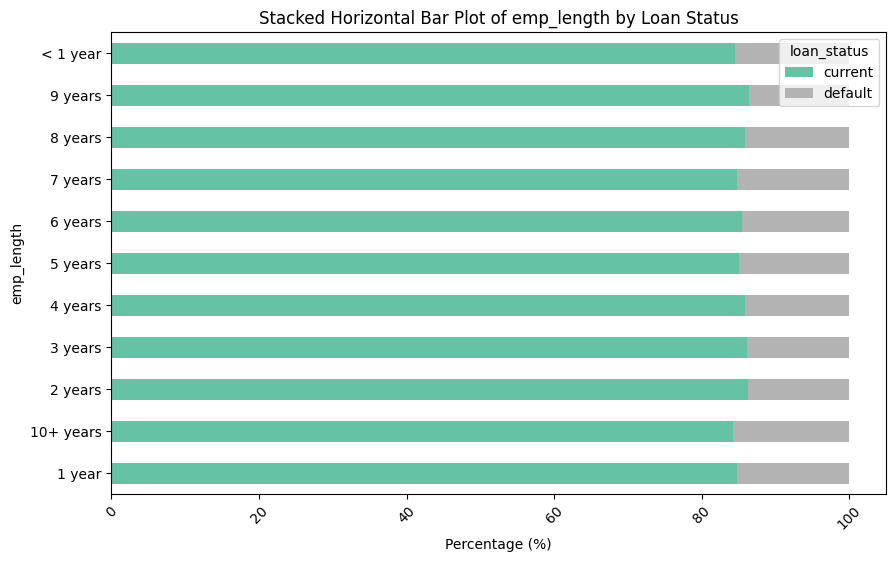

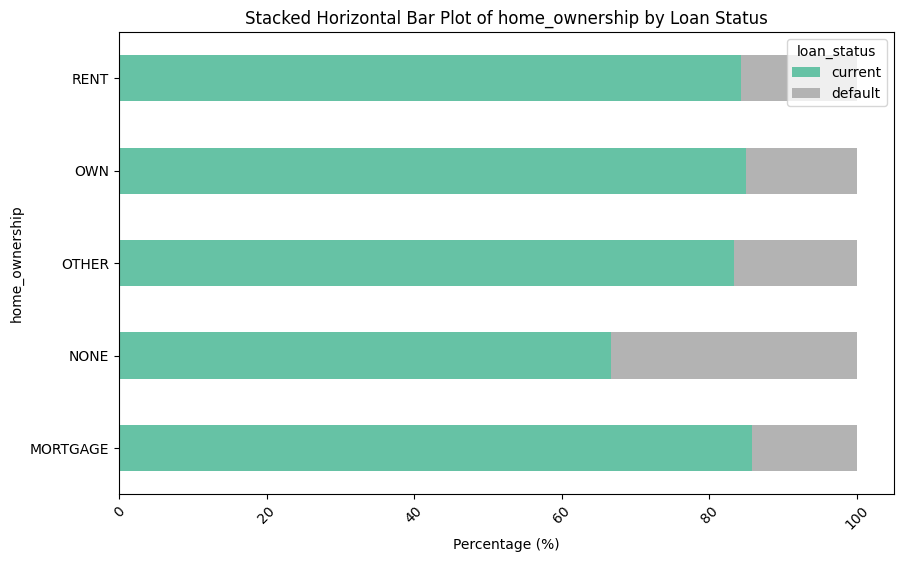

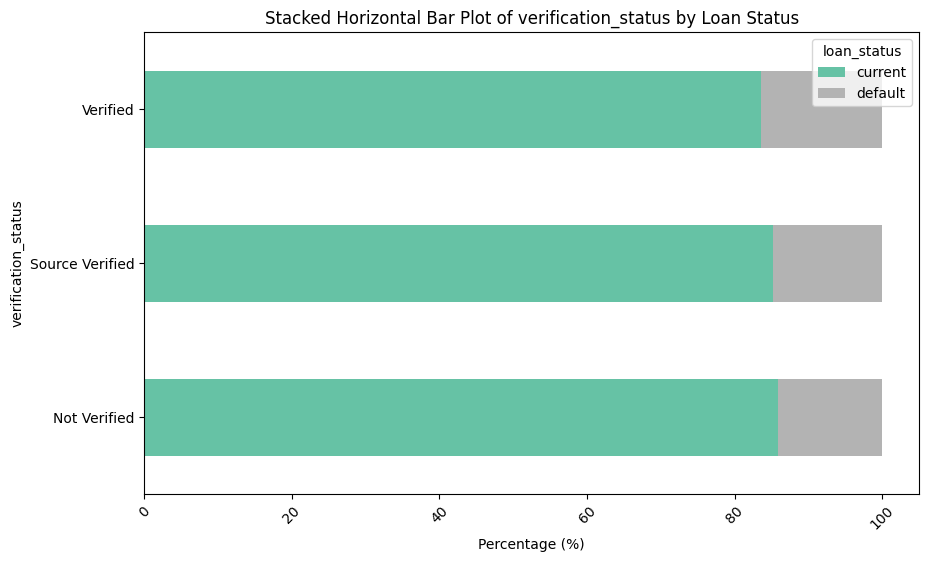

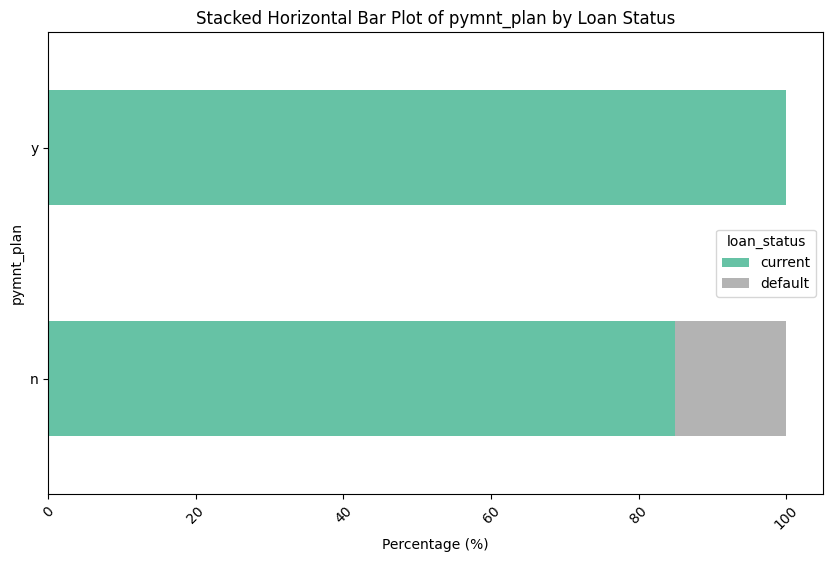

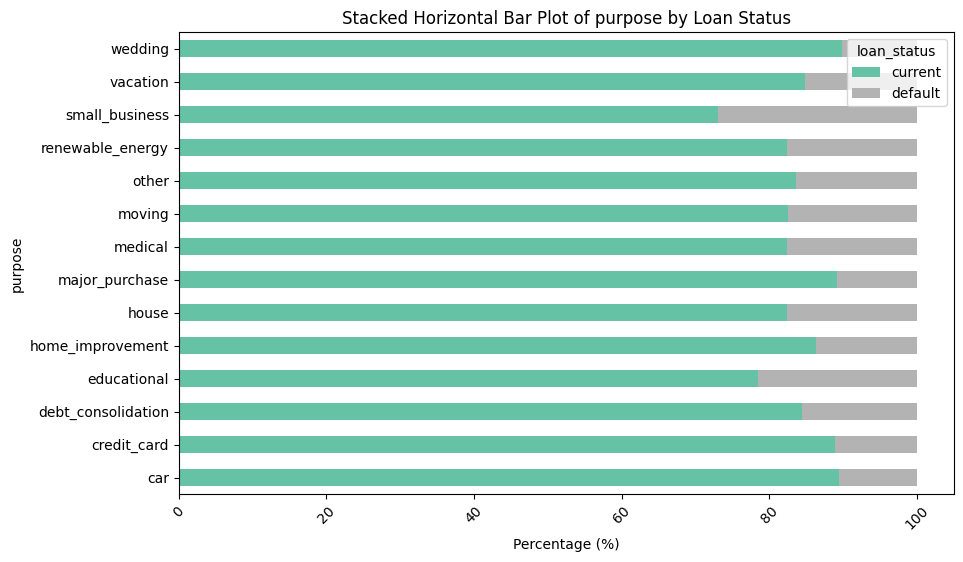

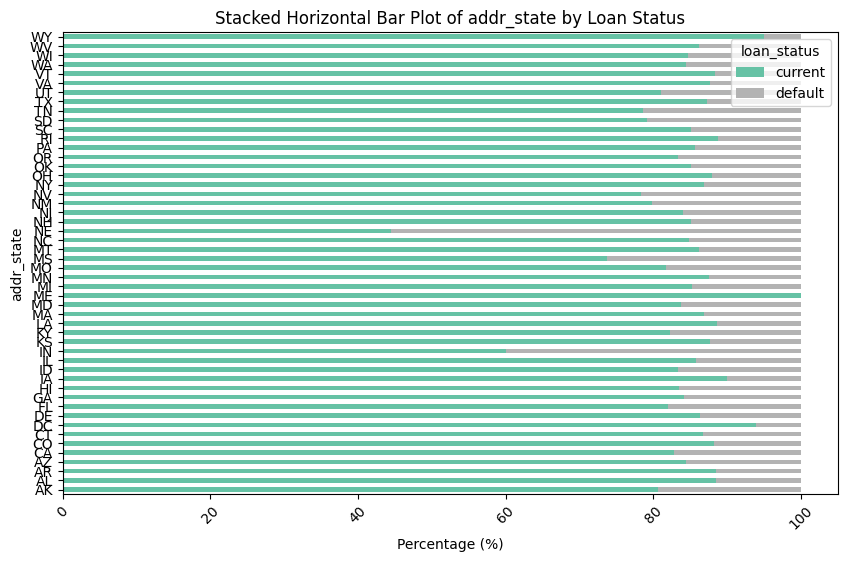

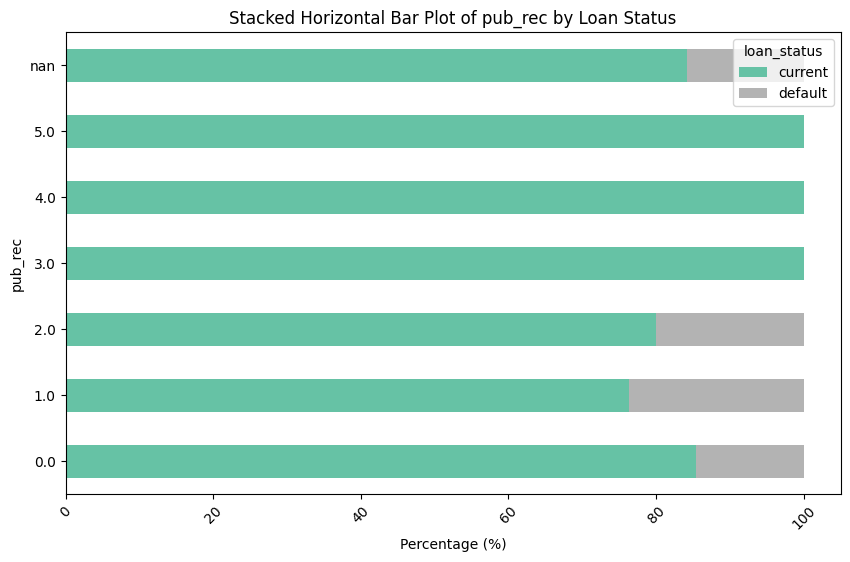

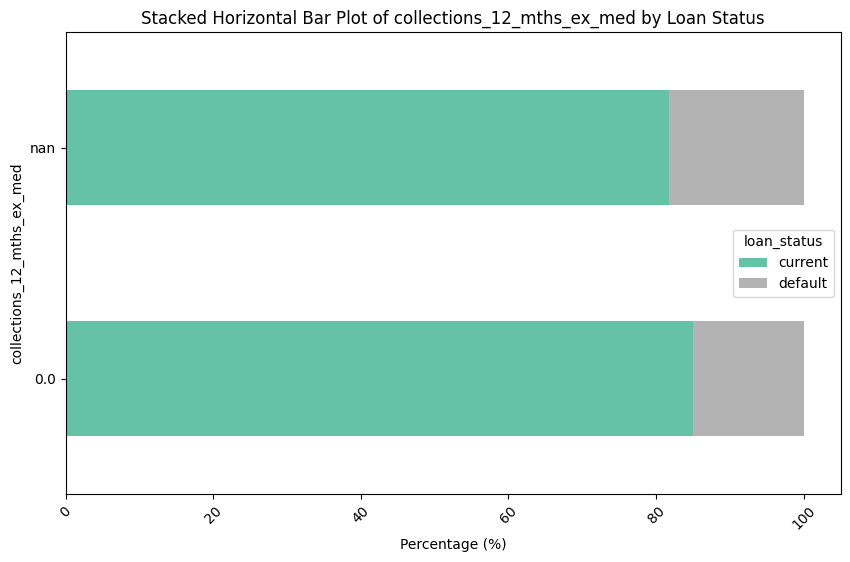

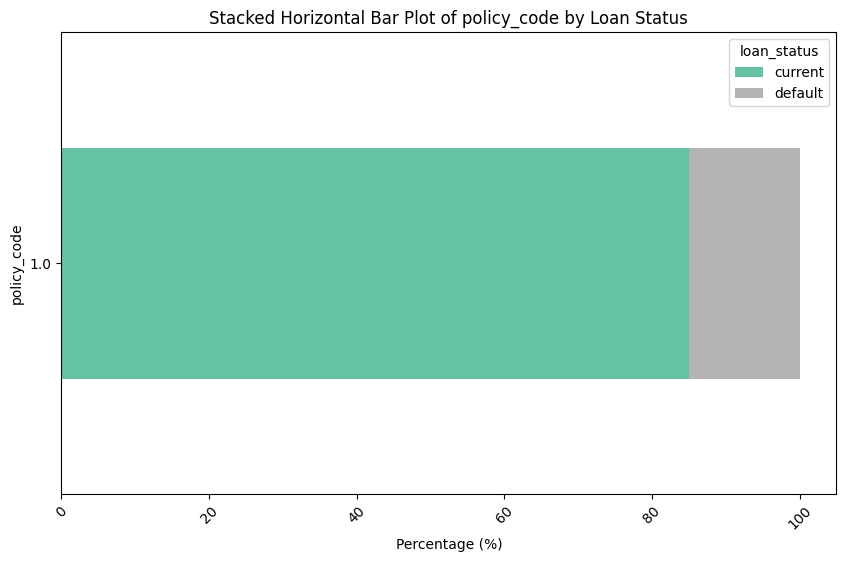

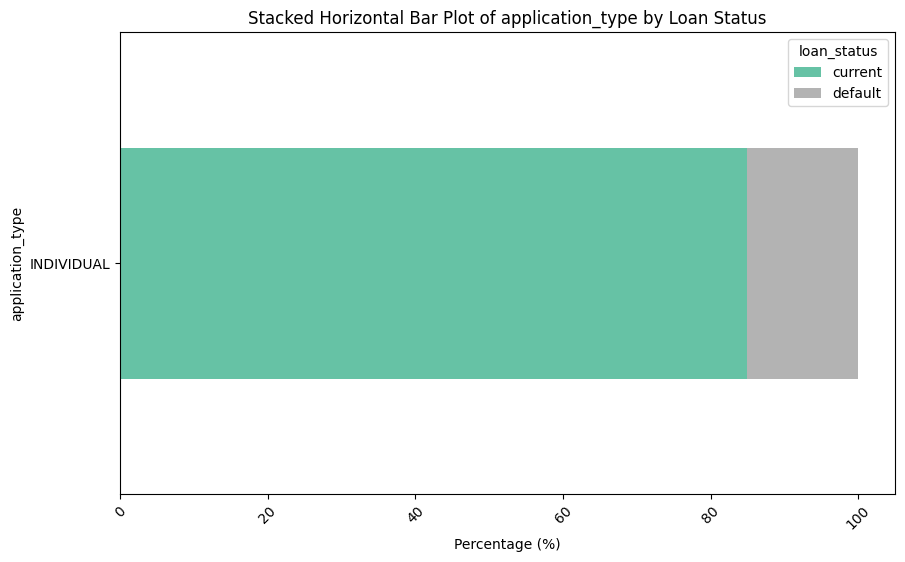

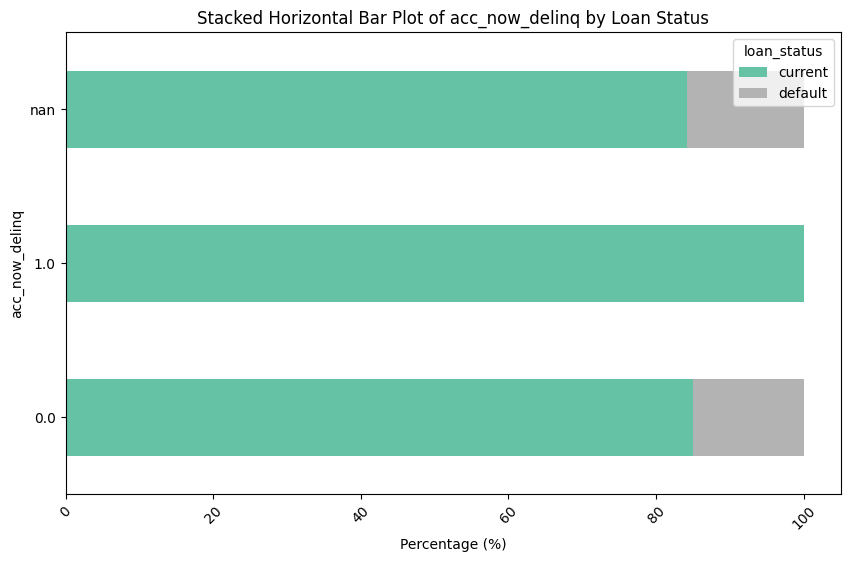

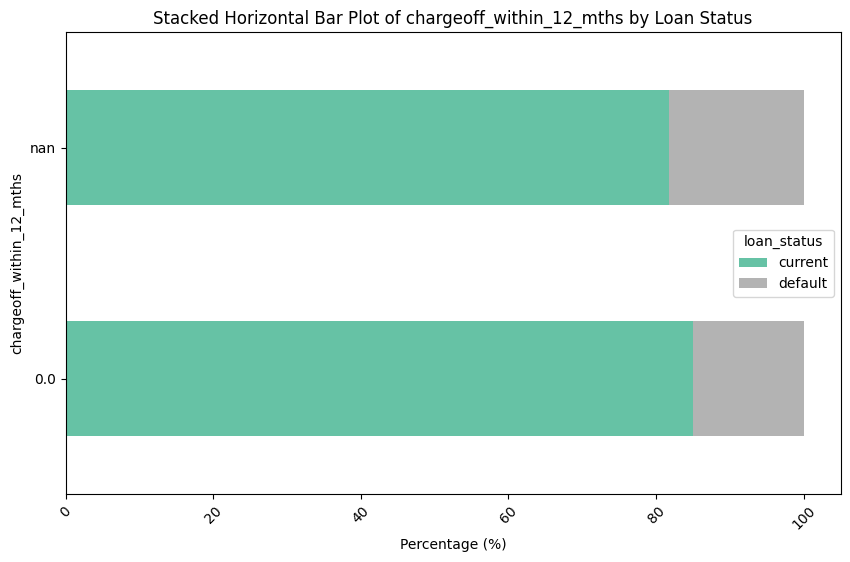

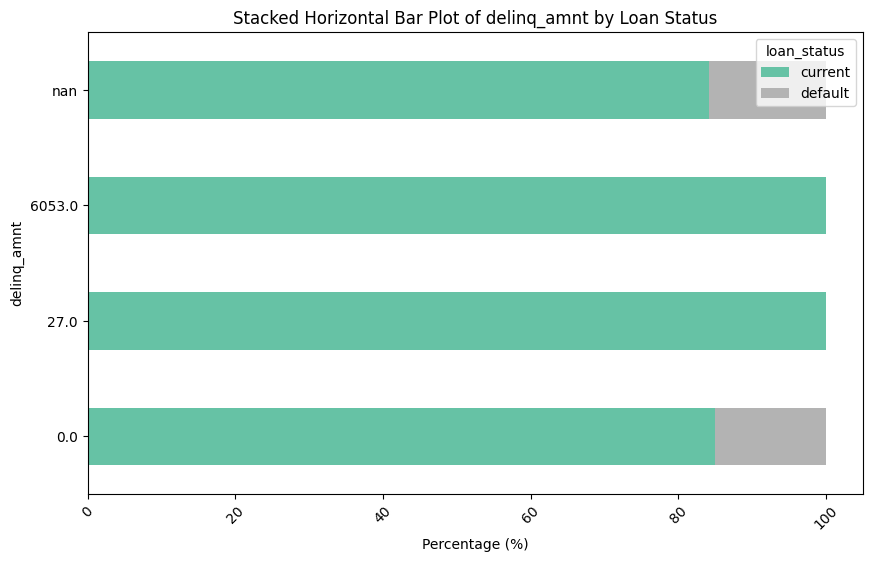

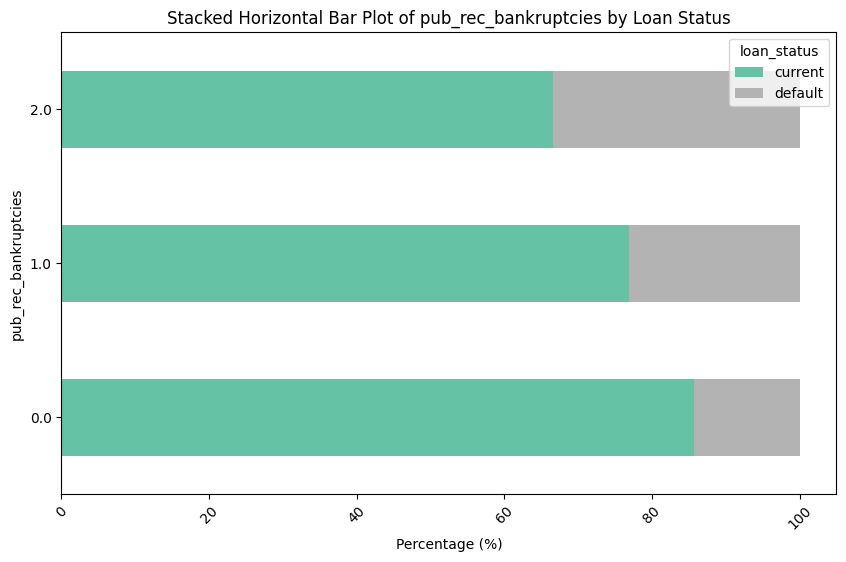

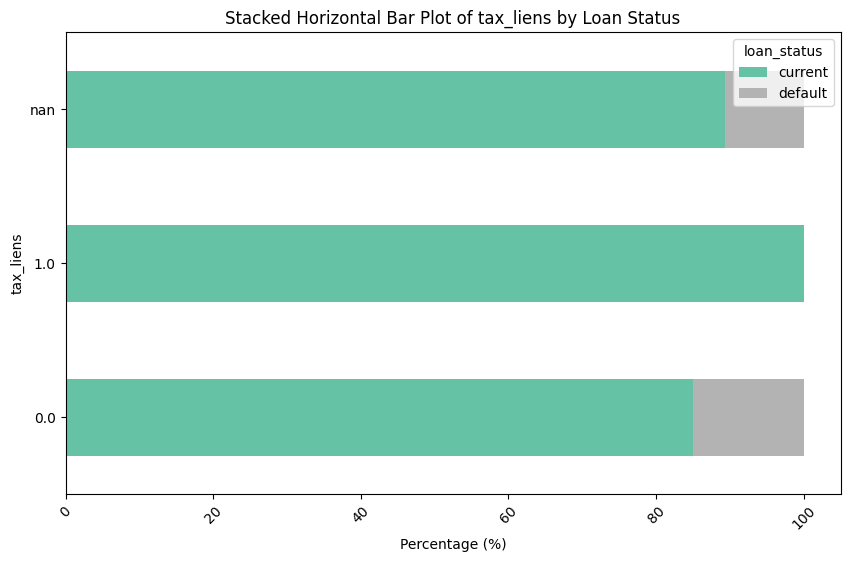

In [14]:
# List of categorical columns
dummy_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
              'pymnt_plan', 'purpose', 'addr_state', 'pub_rec', 'collections_12_mths_ex_med', 
              'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 
              'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens']

# Step 1: Plot Stacked Bar Plot for each column
for col in dummy_cols:
    plot_stacked_bar(col)

In [15]:
def plot_bar(col):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=loan)
    plt.title(f'Distribution of {col} by Loan Status')
    plt.xticks(rotation=45)
    plt.show()

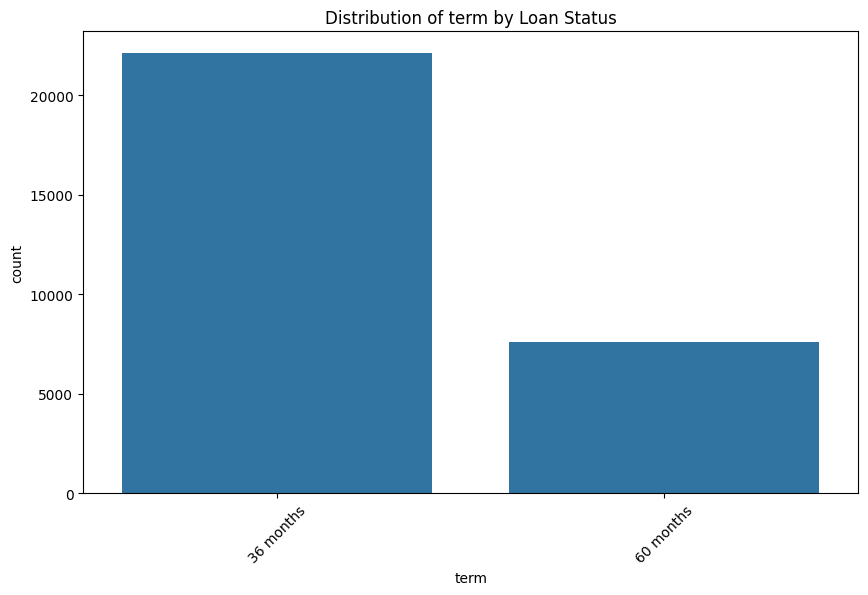

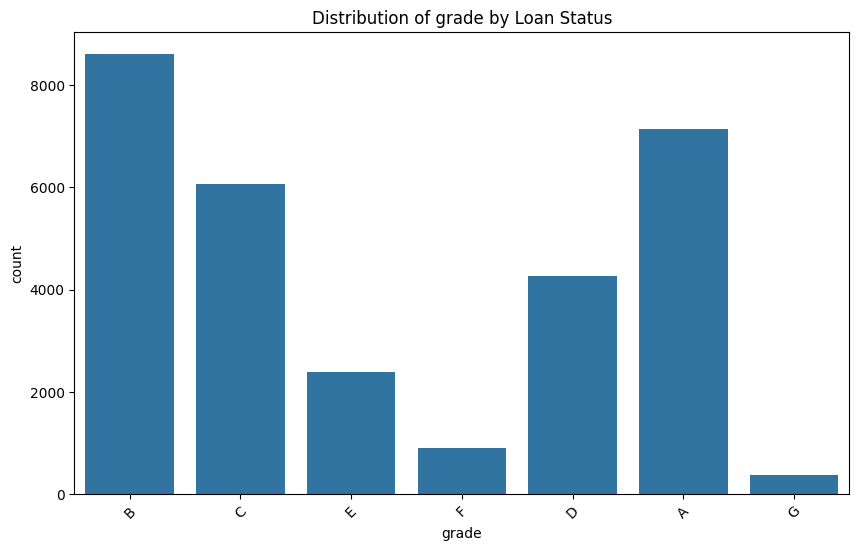

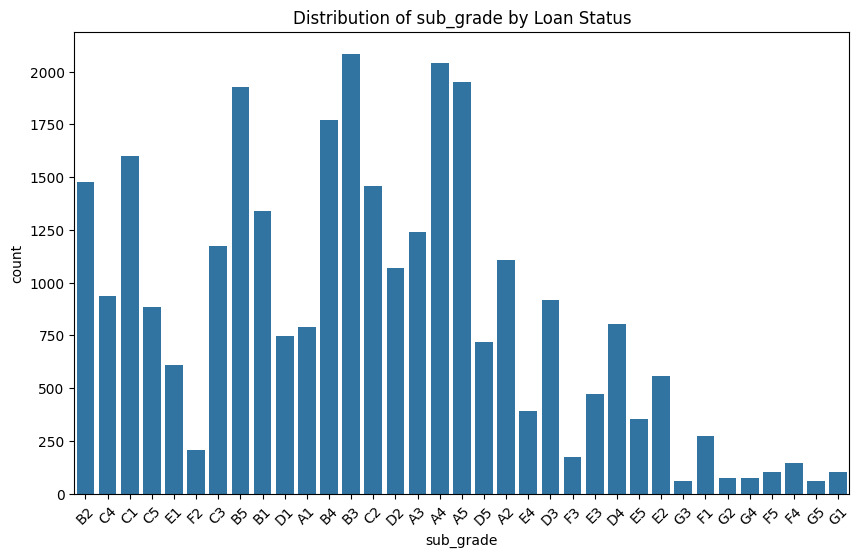

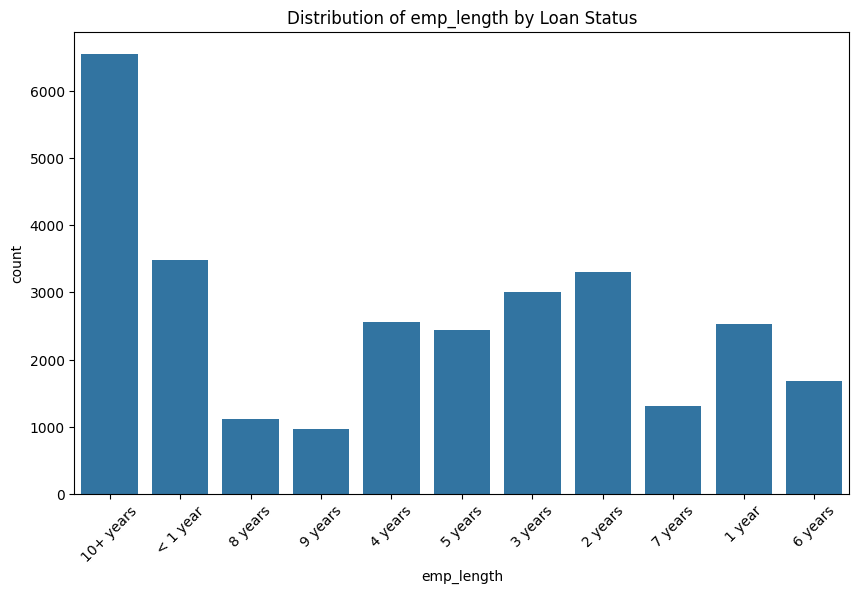

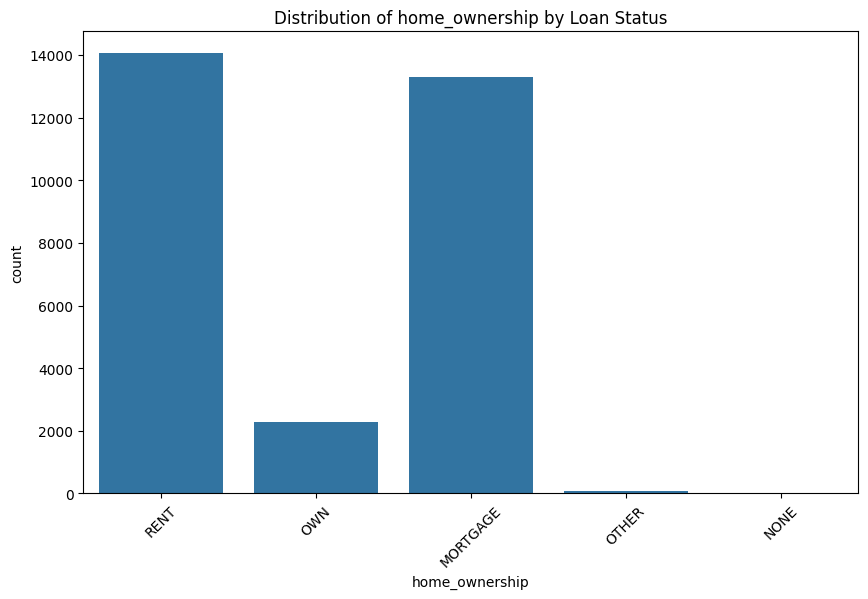

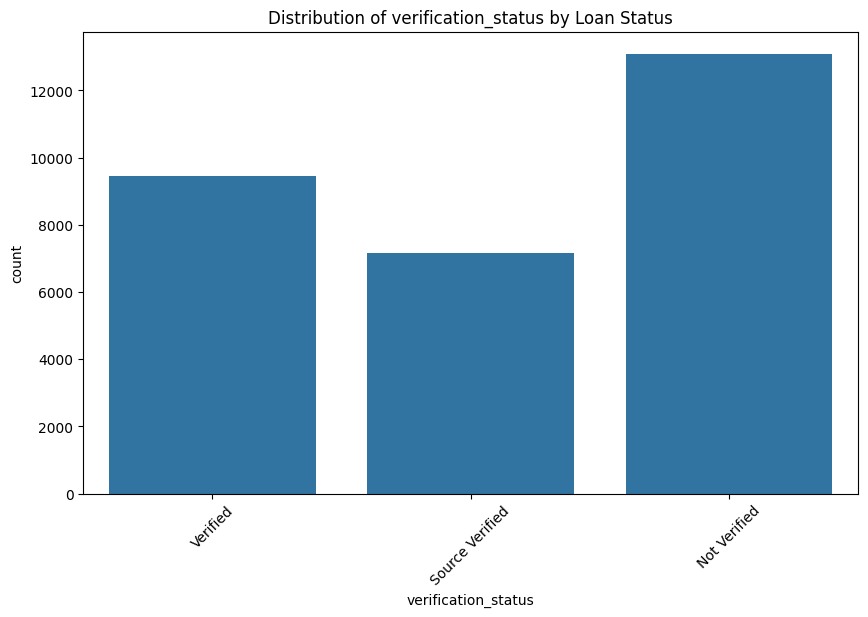

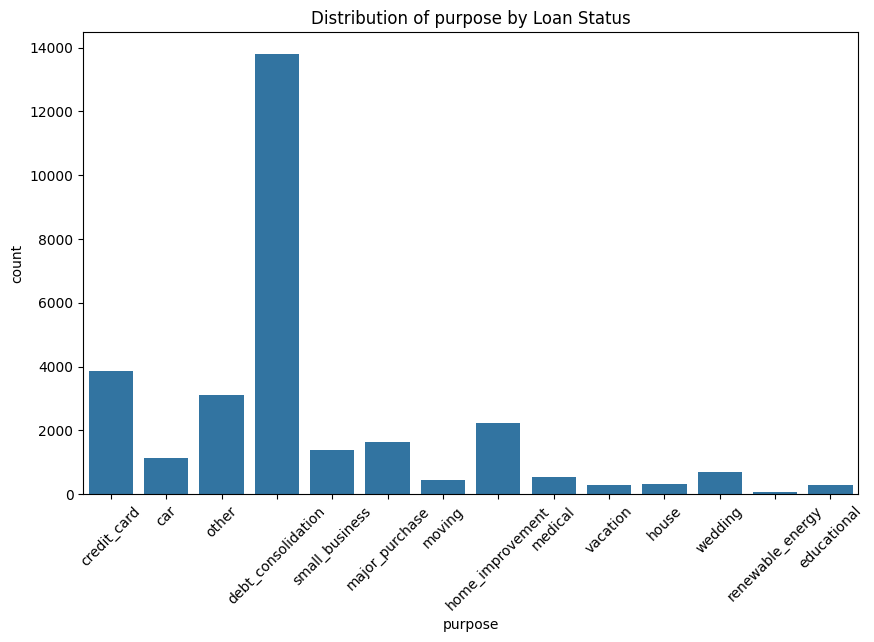

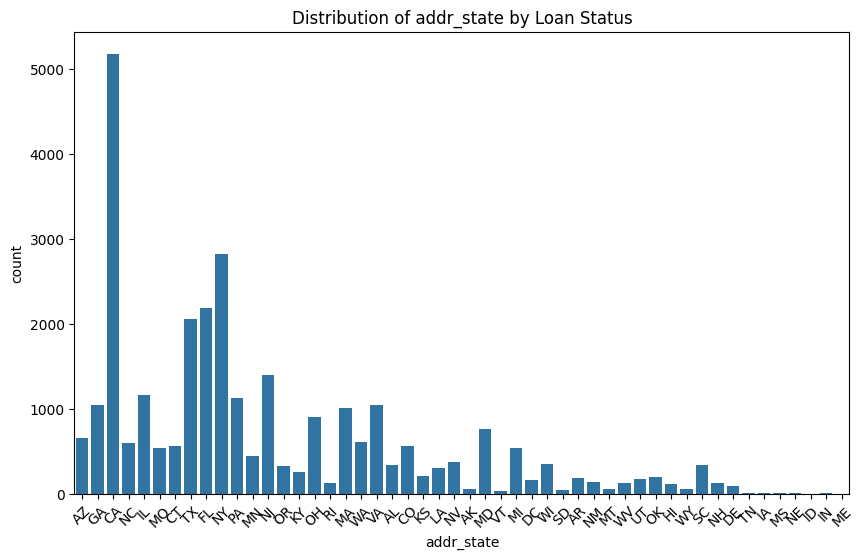

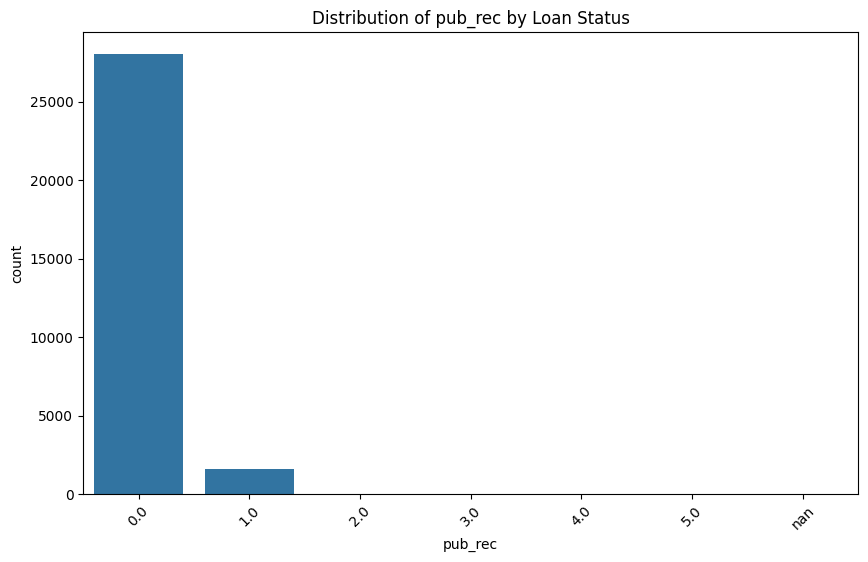

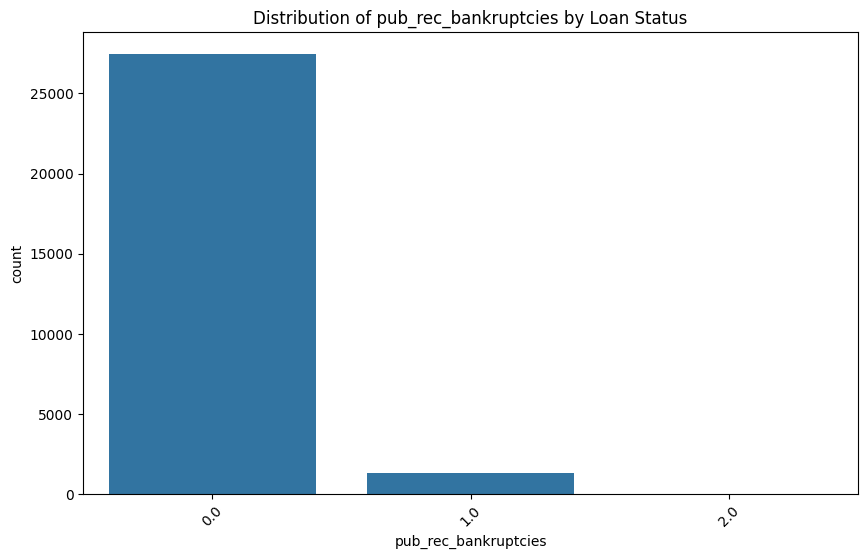

In [16]:
# List of categorical columns (excluding the ones with imbalanced categories)
dummy_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
              'purpose', 'addr_state', 'pub_rec', 'pub_rec_bankruptcies']

# Step 2: Plot Normal Bar Plot for each column
for col in dummy_cols:
    plot_bar(col)

Correlation Analysis

In [17]:
# Correlation analysis
# create a correlation matrix of key numeric varaibles: loan_amnt, funded_amnt, funded_amnt_inv, int_rate, installment, annual_inc, dti, fico_range_low, fico_range_high, open_acc, revol_bal, revol_util, total_acc, last_pymnt_amnt

selected_columns = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
                    'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'open_acc', 
                    'revol_bal', 'revol_util', 'total_acc', 'last_pymnt_amnt']

# Select only the specified columns
cor_analysis = loan[selected_columns].corr()

# Display the correlation matrix
print(cor_analysis)

                 loan_amnt  funded_amnt  funded_amnt_inv  int_rate  \
loan_amnt         1.000000     0.981852         0.929624  0.291540   
funded_amnt       0.981852     1.000000         0.947180  0.294510   
funded_amnt_inv   0.929624     0.947180         1.000000  0.278228   
int_rate          0.291540     0.294510         0.278228  1.000000   
installment       0.930973     0.956668         0.889982  0.271604   
annual_inc        0.407574     0.403942         0.379264  0.084867   
dti               0.066105     0.065130         0.070017  0.117157   
fico_range_low    0.129586     0.121374         0.142430 -0.703546   
fico_range_high   0.129586     0.121374         0.142430 -0.703546   
open_acc          0.180175     0.178003         0.159441  0.031564   
revol_bal         0.278694     0.272886         0.232149  0.088354   
revol_util        0.066253     0.069716         0.070554  0.457855   
total_acc         0.256561     0.250877         0.240014 -0.029886   
last_pymnt_amnt   0.

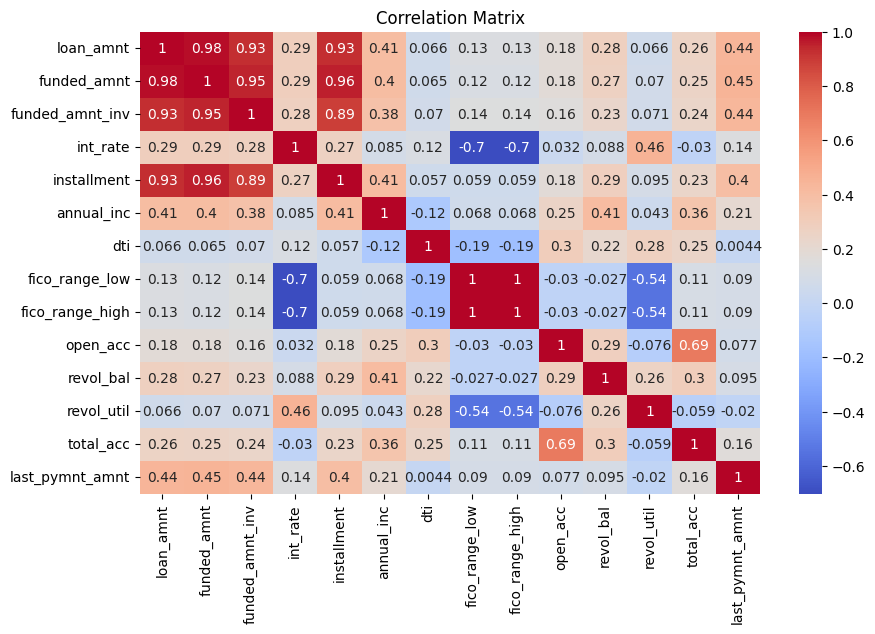

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(cor_analysis, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Feature Transformation and Preparation
loan_decimal = loan.copy()
loan_decimal['loan_status'] = loan_decimal['loan_status'].astype('category')

In [20]:
# Select relevant columns for modeling
data_prep = loan_decimal[['loan_status', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
                          'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 
                          'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_late_fee', 'last_pymnt_amnt', 
                          'issue_d_year', 'earliest_cr_line_year', 'last_pymnt_d_year', 'last_credit_pull_d_year', 
                          'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 
                          'addr_state', 'pub_rec', 'tax_liens']].copy()

# Transforming character columns into categorical data
for col in data_prep.select_dtypes(include='object').columns:
    data_prep[col] = data_prep[col].astype('category')

data_prep.head()

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,addr_state,pub_rec,tax_liens
0,current,5000.0,5000.0,4975.0,0.1065,162.87,24000.0,27.65,0.0,735.0,...,36 months,B,B2,10+ years,RENT,Verified,credit_card,AZ,0.0,0.0
1,default,2500.0,2500.0,2500.0,0.1527,59.83,30000.0,1.00,0.0,740.0,...,60 months,C,C4,< 1 year,RENT,Source Verified,car,GA,0.0,0.0
2,current,10000.0,10000.0,10000.0,0.1349,339.31,49200.0,20.00,0.0,690.0,...,36 months,C,C1,10+ years,RENT,Source Verified,other,CA,0.0,0.0
3,current,7000.0,7000.0,7000.0,0.1596,170.08,47004.0,23.51,0.0,690.0,...,60 months,C,C5,8 years,RENT,Not Verified,debt_consolidation,NC,0.0,0.0
4,current,3000.0,3000.0,3000.0,0.1864,109.43,48000.0,5.35,0.0,660.0,...,36 months,E,E1,9 years,RENT,Source Verified,car,CA,0.0,0.0


In [21]:
# Skim data
skimpy.skim(data_prep)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 29708  │ │ float64     │ 21    │ │ loan_status           │                                │
│ │ Number of columns │ 32     │ │ category    │ 11    │ │ term                  │                                │
│ └───────────────────┴────────┘ └─────────────┴───────┘ │ grade                 │                                │
│                                                        │ sub_grade             │                                │
│                                                        │ emp_length            │                                │
│                                                        │ home_ownership        │                                │
│                                                        │ verification_status   │                                │
│                                                        │ purpose               │                                │
│                                                        │ addr_state            │                                │
│                                                        │ pub_rec               │                                │
│                                                        │ tax_liens             │                                │
│                                                        └───────────────────────┘                                │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column       ┃ NA ┃ NA %          ┃ mean   ┃ sd      ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ loan_amnt    │  0 │             0 │  11100 │    7397 │    500 │   5200 │   9750 │  15000 │  35000 │ ▇▇▅▂▂▁ │  │
│ │ funded_amnt  │  0 │             0 │  10830 │    7139 │    500 │   5075 │   9600 │  15000 │  35000 │ ▇▇▅▂▁▁ │  │
│ │ funded_amnt_ │  0 │             0 │  10150 │    7125 │      0 │   4950 │   8500 │  14000 │  35000 │ ▇▇▅▂▁▁ │  │
│ │ inv          │    │               │        │         │        │        │        │        │        │        │  │
│ │ int_rate     │  0 │             0 │ 0.1217 │ 0.03716 │ 0.0542 │ 0.0963 │ 0.1199 │ 0.1472 │ 0.2411 │ ▆▇▇▅▂  │  │
│ │ installment  │  0 │             0 │  323.5 │   209.4 │  15.67 │  165.8 │  278.6 │  429.2 │   1305 │  ▇▇▃▁  │  │
│ │ annual_inc   │  0 │             0 │  67580 │   42010 │   2000 │  40000 │  58610 │  82000 │ 487000 │   ▇▂   │  │
│ │ dti          │  0 │             0 │   13.4 │   6.729 │      0 │   8.21 │   13.5 │   18.7 │  29.99 │ ▅▇▇▇▆▁ │  │
│ │ delinq_2yrs  │ 19 │ 0.06395583681 │ 0.1549 │  0.5241 │      0 │      0 │      0 │      0 │     13 │   ▇    │  │
│ │              │    │        163323 │        │         │        │        │        │        │        │        │  │
│ │ fico_range_l │  0 │             0 │    713 │   36.31 │    610 │    685 │    710 │    740 │    825 │  ▅▇▆▃▁ │  │
│ │ ow           │    │               │        │         │        │        │        │        │        │        │  │
│ │ fico_range_h │  0 │             0 │    717 │   36.31 │    614 │    689 │    714 │    744 │    829 │  ▅▇▆▃▁ │  │
│ │ igh          │    │               │        │        

In [22]:
len(data_prep)

29708

In [23]:
#data_prep = data_prep.dropna()
#len(data_prep)

Remove Anomaly Records (Isolation Forest)

In [24]:
data_prep.dtypes

loan_status                category
loan_amnt                   float64
funded_amnt                 float64
funded_amnt_inv             float64
int_rate                    float64
installment                 float64
annual_inc                  float64
dti                         float64
delinq_2yrs                 float64
fico_range_low              float64
fico_range_high             float64
inq_last_6mths              float64
open_acc                    float64
revol_bal                   float64
revol_util                  float64
total_acc                   float64
total_rec_late_fee          float64
last_pymnt_amnt             float64
issue_d_year                float64
earliest_cr_line_year       float64
last_pymnt_d_year           float64
last_credit_pull_d_year     float64
term                       category
grade                      category
sub_grade                  category
emp_length                 category
home_ownership             category
verification_status        c

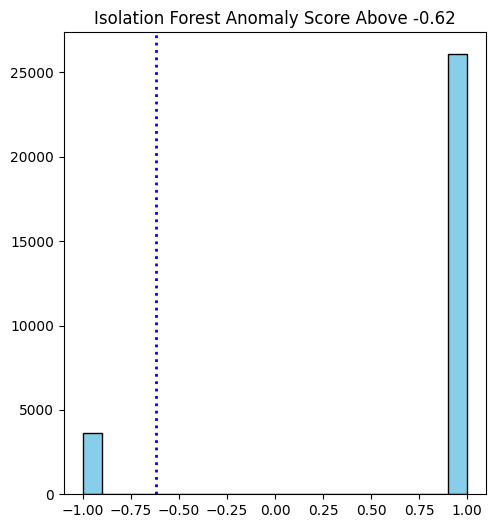

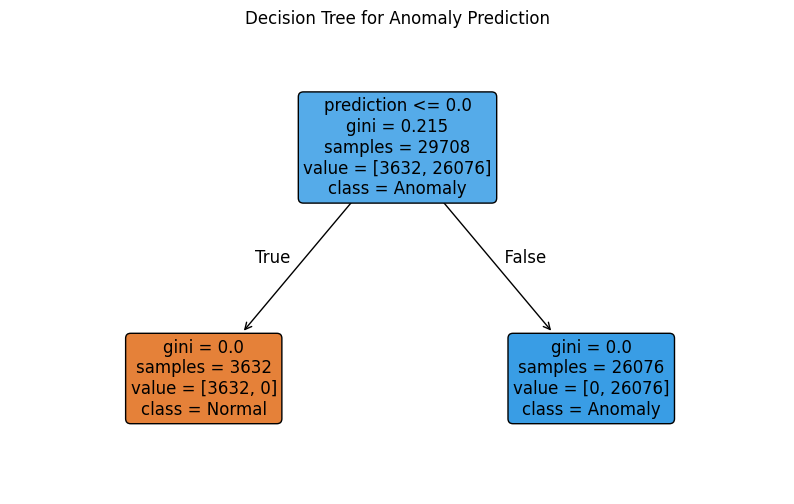

prediction <= 0.0
prediction > 0.0


In [25]:
# Step 1: Select only numeric data
loan_numeric = data_prep.select_dtypes(include=[np.number])  # Select only numeric columns

# Step 2: Handle missing values (impute numeric data with median)
imputer = SimpleImputer(strategy='median')  # Impute missing numeric values with the median
loan_numeric_imputed = imputer.fit_transform(loan_numeric)  # Apply imputation

# Step 3: Train Isolation Forest model for anomaly detection
# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, max_samples=256, contamination='auto', random_state=42)
iso_forest.fit(loan_numeric_imputed)

# Step 4: Predict anomalies and visualize
# Get anomaly scores (negative_outlier_factor is the anomaly score)
pred_train = iso_forest.decision_function(loan_numeric_imputed)
anomaly_scores = iso_forest.predict(loan_numeric_imputed)

# Convert anomaly scores to a DataFrame for analysis
anomaly_df = pd.DataFrame({
    'anomaly_score': pred_train,
    'prediction': anomaly_scores
})

# Plot histograms of anomaly scores
plt.figure(figsize=(12, 6))

# Histogram of average depth (use anomaly score directly for this purpose)
plt.subplot(1, 2, 1)
plt.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=-0.62, color='blue', linestyle='dotted', linewidth=2)
plt.title('Isolation Forest Anomaly Score Above -0.62')

# Show the plots
plt.show()

# Step 5: Global level interpretation - train a decision tree to predict anomalies
# Create a new dataframe with anomaly flag
train_pred = pd.concat([anomaly_df, pd.DataFrame(loan_numeric_imputed)], axis=1)
train_pred['anomaly'] = np.where(train_pred['prediction'] == -1, 'Anomaly', 'Normal')

# Ensure column names are strings
X = train_pred.drop(columns=['anomaly']).copy()
X.columns = X.columns.astype(str)  # Convert column names to strings

y = train_pred['anomaly']

# Train the decision tree
outlier_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
outlier_tree.fit(X, y)

# Visualize the decision tree
plt.figure(figsize=(10, 6))
plot_tree(outlier_tree, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Normal', 'Anomaly'], 
          rounded=True, 
          fontsize=12)  # Set smaller font size
plt.title('Decision Tree for Anomaly Prediction')
plt.show()

# Step 6: Extract and display rules from the decision tree
# Decision tree rules are automatically generated by the tree structure
# Extract decision tree rules

tree_rules = []

def extract_rules(tree, feature_names, node_id=0, rule=[]):
    if tree.feature[node_id] != -2:  # Check if it's not a leaf node
        feature_name = feature_names[tree.feature[node_id]]
        threshold = tree.threshold[node_id]
        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]
        
        # Rule for left child
        rule_left = rule + [f"{feature_name} <= {threshold}"]
        # Rule for right child
        rule_right = rule + [f"{feature_name} > {threshold}"]
        
        # Recur for left and right branches
        extract_rules(tree, feature_names, left_child, rule_left)
        extract_rules(tree, feature_names, right_child, rule_right)
    else:
        # If it's a leaf node, append the rule
        tree_rules.append(rule)

# Extract rules from the trained decision tree
extract_rules(outlier_tree.tree_, X.columns)

# Show the extracted rules
for r in tree_rules:
    print(" AND ".join(r))

In [26]:
# Ensure the model is trained with feature names
iso_forest.fit(loan_numeric)

# Predict the anomaly scores using Isolation Forest
anomaly_scores = iso_forest.decision_function(loan_numeric)

# Concatenate the anomaly scores with the original data
pred_train = pd.concat([loan_numeric, pd.Series(anomaly_scores, name='anomaly_score')], axis=1)

# Sort the records by anomaly score and select the top 5 most anomalous records
top_anomalous = pred_train.sort_values(by='anomaly_score', ascending=False).head(5)

# Display the most anomalous records
print(top_anomalous.index)

Index([6265, 20945, 9453, 5298, 19763], dtype='int64')


In [27]:
anomalous_indices = top_anomalous.index  # Use the indices of the top anomalous records
data = data_prep.drop(data_prep.index[anomalous_indices], axis=0)  # Removing the anomalous rows

In [28]:
len(data)

29703

Partition My Data into 70/30 Train/Test Split

In [29]:
# Set the random seed for reproducibility
random_seed = 1234

# Perform 70/30 train-test split
train, test = train_test_split(data, test_size=0.3, random_state=random_seed)

# Print the percentage of data in each split
print("Train PCT : {:.2f}%".format(len(train) / len(data) * 100))
print("Test  PCT : {:.2f}%".format(len(test) / len(data) * 100))

Train PCT : 70.00%
Test  PCT : 30.00%


Logistic Regression (full model)

In [30]:
# Define features and target
X = train.drop('loan_status', axis=1)
y = train['loan_status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing Pipeline for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Logistic Regression Model
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Fit model
logreg.fit(X_train, y_train)

# Make predictions
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
y_train_prob = logreg.predict_proba(X_train)[:, 1]
y_test_prob = logreg.predict_proba(X_test)[:, 1]

Evalution the full model

Training Classification Report:
              precision    recall  f1-score   support

     current       0.95      0.98      0.96     12365
     default       0.85      0.72      0.78      2189

    accuracy                           0.94     14554
   macro avg       0.90      0.85      0.87     14554
weighted avg       0.94      0.94      0.94     14554

Testing Classification Report:
              precision    recall  f1-score   support

     current       0.95      0.98      0.97      5309
     default       0.86      0.71      0.78       929

    accuracy                           0.94      6238
   macro avg       0.91      0.85      0.87      6238
weighted avg       0.94      0.94      0.94      6238



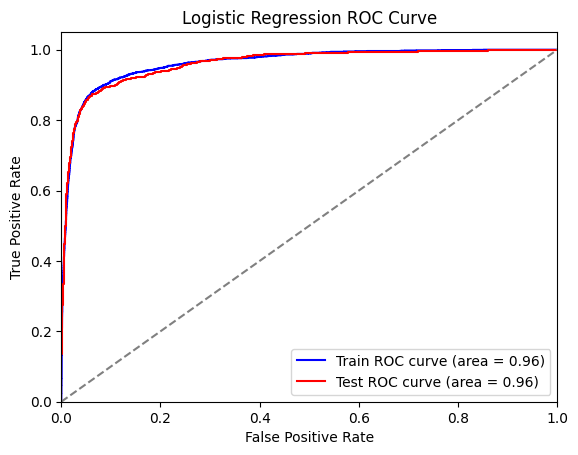

In [31]:
# Evaluation metrics
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Convert categorical labels to binary labels (e.g., 'current' -> 0, 'default' -> 1)
y_train_binary = y_train.map({'current': 0, 'default': 1})
y_test_binary = y_test.map({'current': 0, 'default': 1})

# Now, you can call the roc_curve function with the binary labels
fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_test_prob)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

Lasso L1 Regularization

In [32]:
lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=1000))
])

# Fit Lasso model
lasso.fit(X_train, y_train)

# Make predictions for Lasso model
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)
y_train_prob_lasso = lasso.predict_proba(X_train)[:, 1]
y_test_prob_lasso = lasso.predict_proba(X_test)[:, 1]

Evaluation metrics for Lasso

Training Classification Report (Lasso):
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     12365
           1       0.85      0.73      0.79      2189

    accuracy                           0.94     14554
   macro avg       0.90      0.85      0.88     14554
weighted avg       0.94      0.94      0.94     14554

Testing Classification Report (Lasso):
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5309
           1       0.86      0.73      0.79       929

    accuracy                           0.94      6238
   macro avg       0.91      0.85      0.88      6238
weighted avg       0.94      0.94      0.94      6238

Training Confusion Matrix (Lasso):
[[12087   278]
 [  594  1595]]
Testing Confusion Matrix (Lasso):
[[5197  112]
 [ 255  674]]


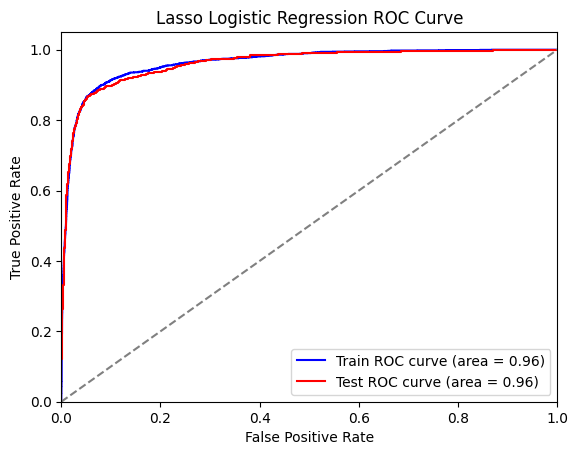

Selected Features from Lasso:
['loan_amnt' 'funded_amnt' 'funded_amnt_inv' 'int_rate' 'installment'
 'annual_inc' 'dti' 'delinq_2yrs' 'fico_range_low' 'fico_range_high'
 'inq_last_6mths' 'open_acc' 'revol_bal' 'revol_util' 'total_acc'
 'total_rec_late_fee' 'last_pymnt_amnt' 'issue_d_year'
 'earliest_cr_line_year' 'last_pymnt_d_year' 'last_credit_pull_d_year']


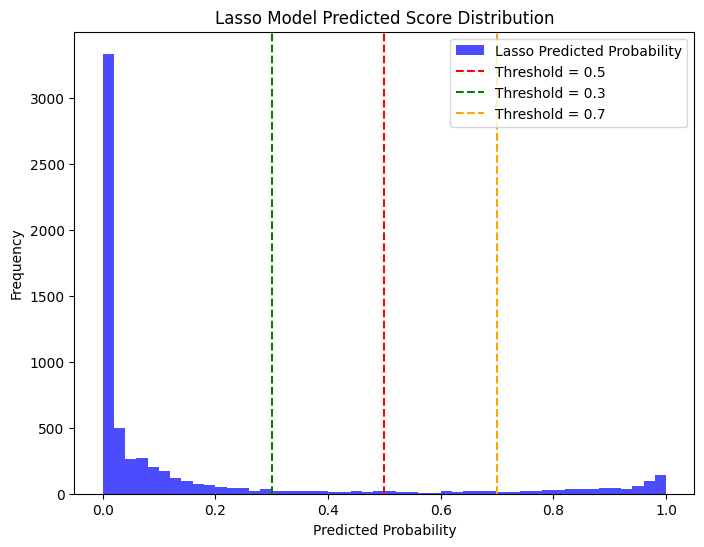

Operating Range (FPR <= 0.5) for Lasso:
          fpr       tpr
0    0.000000  0.000000
1    0.000000  0.001076
2    0.000000  0.022605
3    0.000188  0.022605
4    0.000188  0.071044
..        ...       ...
542  0.438501  0.988159
543  0.475796  0.988159
544  0.475796  0.989236
545  0.485779  0.989236
546  0.485779  0.990312

[547 rows x 2 columns]


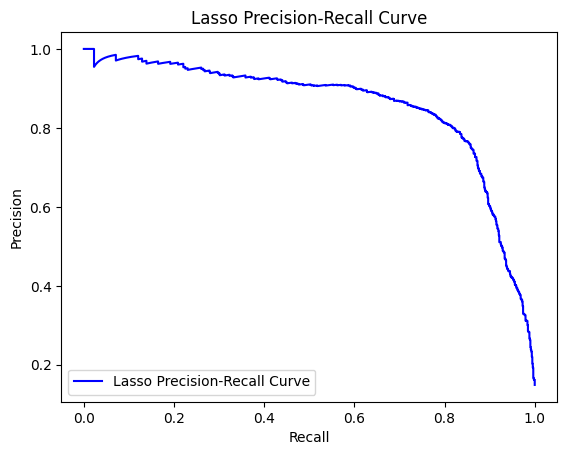

In [33]:
# Fit the entire pipeline first
lasso.fit(X_train, y_train_binary)

# Convert categorical predictions to binary values (e.g., 'current' -> 0, 'default' -> 1)
y_train_pred_binary = np.where(y_train_pred_lasso == 'current', 0, 1)
y_test_pred_binary = np.where(y_test_pred_lasso == 'current', 0, 1)

# Now, you can use the binary predictions and true labels to generate the classification report
print("Training Classification Report (Lasso):")
print(classification_report(y_train_binary, y_train_pred_binary))

print("Testing Classification Report (Lasso):")
print(classification_report(y_test_binary, y_test_pred_binary))

# Confusion Matrix for Lasso
cm_train_lasso = confusion_matrix(y_train_binary, y_train_pred_binary)
cm_test_lasso = confusion_matrix(y_test_binary, y_test_pred_binary)

print("Training Confusion Matrix (Lasso):")
print(cm_train_lasso)

print("Testing Confusion Matrix (Lasso):")
print(cm_test_lasso)

# Now, you can call the roc_curve function with the binary labels for Lasso model
fpr_train_lasso, tpr_train_lasso, _ = roc_curve(y_train_binary, y_train_prob_lasso)
fpr_test_lasso, tpr_test_lasso, _ = roc_curve(y_test_binary, y_test_prob_lasso)

roc_auc_train_lasso = auc(fpr_train_lasso, tpr_train_lasso)
roc_auc_test_lasso = auc(fpr_test_lasso, tpr_test_lasso)

# Plot the ROC curve for Lasso model
plt.figure()
plt.plot(fpr_train_lasso, tpr_train_lasso, color='blue', label=f'Train ROC curve (area = {roc_auc_train_lasso:.2f})')
plt.plot(fpr_test_lasso, tpr_test_lasso, color='red', label=f'Test ROC curve (area = {roc_auc_test_lasso:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lasso Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Selection with Lasso
# Access the OneHotEncoder from the pipeline, then fit and extract the feature names
preprocessor = lasso.named_steps['preprocessor']
onehot_encoder = preprocessor.transformers_[1][1]['onehot']

# Fit the OneHotEncoder separately if it hasn't been fitted yet
onehot_encoder.fit(X_train[categorical_features])

# Now, extract the feature names
onehot_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

# Combine numeric and categorical features
lasso_coef = lasso.named_steps['classifier'].coef_.flatten()
lasso_selected_features = np.array(numeric_features.tolist() + list(onehot_feature_names))

# Selecting non-zero coefficients
lasso_selected_features = lasso_selected_features[lasso_coef != 0]
print("Selected Features from Lasso:")
print(lasso_selected_features)

# Score Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_test_prob_lasso, bins=50, color='blue', alpha=0.7, label='Lasso Predicted Probability')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.axvline(x=0.3, color='green', linestyle='--', label='Threshold = 0.3')
plt.axvline(x=0.7, color='orange', linestyle='--', label='Threshold = 0.7')
plt.title('Lasso Model Predicted Score Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Operating Range for Lasso (FPR <= 0.5)
fpr_test_lasso_df = pd.DataFrame({'fpr': fpr_test_lasso, 'tpr': tpr_test_lasso})
operating_range_lasso = fpr_test_lasso_df[fpr_test_lasso_df['fpr'] <= 0.5]
print("Operating Range (FPR <= 0.5) for Lasso:")
print(operating_range_lasso)

# Precision-Recall Curve
precision_lasso, recall_lasso, thresholds_lasso = precision_recall_curve(y_test_binary, y_test_prob_lasso)

plt.plot(recall_lasso, precision_lasso, color='blue', label='Lasso Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Lasso Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

Recipe & Bake

In [34]:
# Split original data into features and labels
X = train.drop('loan_status', axis=1)
y = train['loan_status']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Define numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Neural Network Model

In [35]:
# Neural network and hyperparameter grid
nn_model = MLPClassifier(max_iter=1000, solver='adam', random_state=42)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# K-fold CV and grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=nn_model, param_grid=param_grid, cv=kfold,
                           scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_transformed, y_train)

# Best results
best_params = grid_search.best_params_
best_auc = grid_search.best_score_
print(f"Best hyperparameters: {best_params}")
print(f"Best AUC score: {best_auc:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}
Best AUC score: 0.9689


Model Evaluation

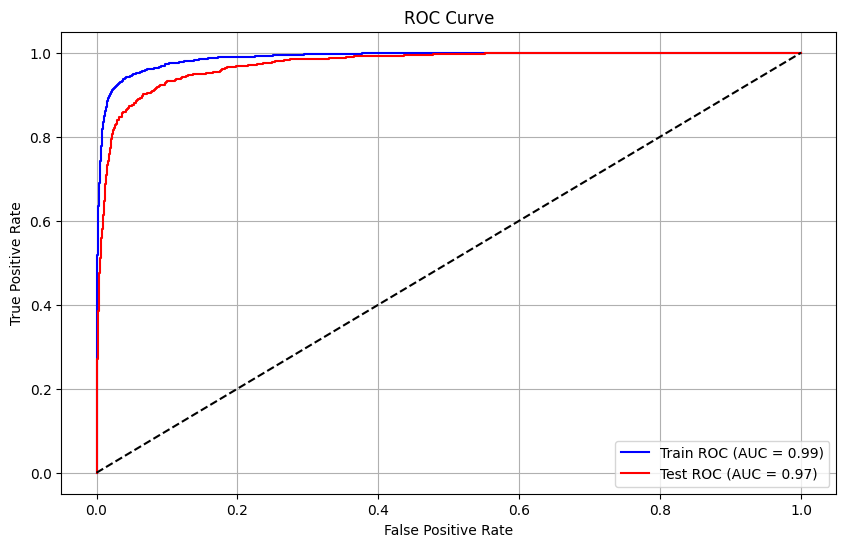

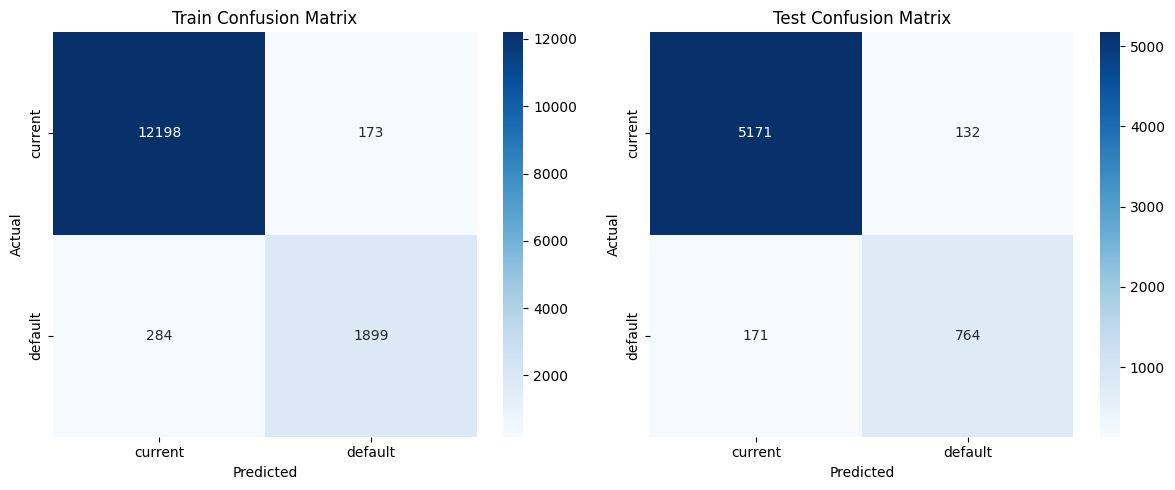

In [36]:
# Convert labels for binary classification
y_train_numeric = y_train.map({'current': 0, 'default': 1})
y_test_numeric = y_test.map({'current': 0, 'default': 1})

# Predict probabilities
y_pred_train_prob = grid_search.predict_proba(X_train_transformed)[:, 1]
y_pred_test_prob = grid_search.predict_proba(X_test_transformed)[:, 1]

# ROC curve and AUC
fpr_train, tpr_train, _ = roc_curve(y_train_numeric, y_pred_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_numeric, y_pred_test_prob)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC with AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Predict class labels
y_pred_train_class = grid_search.predict(X_train_transformed)
y_pred_test_class = grid_search.predict(X_test_transformed)

# Convert predicted labels to numeric
y_pred_train_numeric = pd.Series(y_pred_train_class).map({'current': 0, 'default': 1})
y_pred_test_numeric = pd.Series(y_pred_test_class).map({'current': 0, 'default': 1})

# Confusion matrices
cm_train = confusion_matrix(y_train_numeric, y_pred_train_numeric)
cm_test = confusion_matrix(y_test_numeric, y_pred_test_numeric)

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['current', 'default'], yticklabels=['current', 'default'])
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['current', 'default'], yticklabels=['current', 'default'])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

Variable Importance

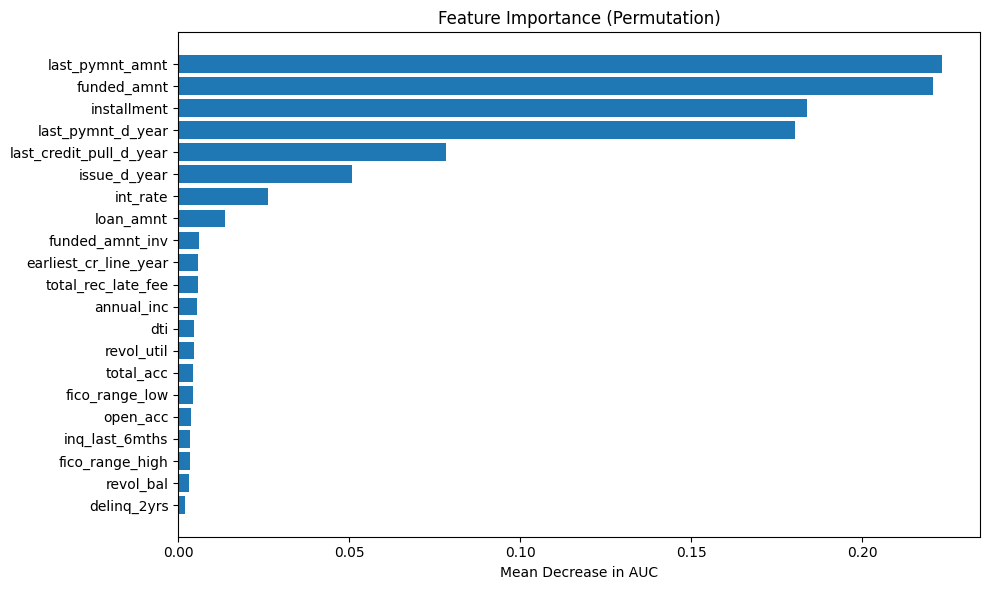

In [37]:
# Compute feature importance using permutation on the training set
result = permutation_importance(
    grid_search.best_estimator_,
    X_train_transformed,
    y_train_numeric,       # Use numeric labels
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'      # You can also use 'accuracy' if preferred
)

# Extract mean importance scores and sort them
importances = result.importances_mean
indices = importances.argsort()

# Define feature names (modify if using ColumnTransformer or Pipeline)
feature_names = X.columns  # Replace this with transformed feature names if applicable

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Permutation)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Mean Decrease in AUC")
plt.tight_layout()
plt.show()

Precision-Recall Curve

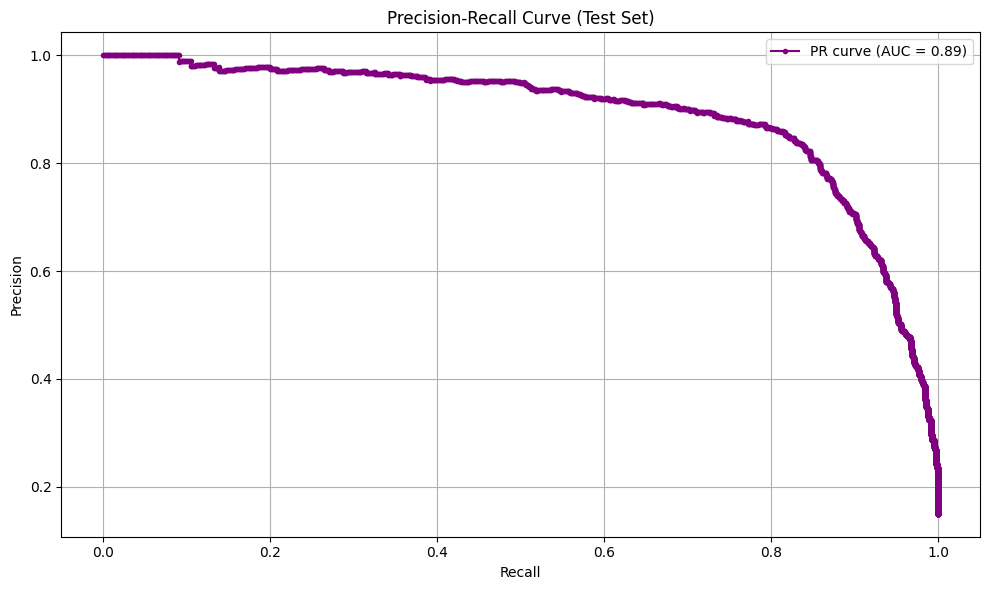

In [38]:
# Compute Precision-Recall curve for the test set
precision, recall, thresholds = precision_recall_curve(y_test_numeric, y_pred_test_prob)

# Compute AUC for Precision-Recall curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='purple', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Visualizing Neural Network

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5361 - loss: 0.6923  
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5393 - loss: 0.6844 
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6527 - loss: 0.6692 
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6817 - loss: 0.6634 
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6553 - loss: 0.6552 


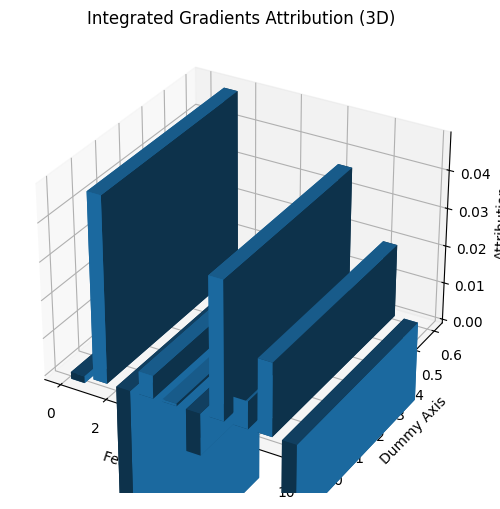

In [39]:
# ----------------- Integrated Gradients Function -----------------
def compute_integrated_gradients(model, input_tensor, baseline=None, steps=50, target_class_index=1):
    if baseline is None:
        baseline = np.zeros_like(input_tensor)

    # Ensure input_tensor and baseline are the correct shape (1, features)
    input_tensor = input_tensor[0]
    baseline = baseline[0]

    # Generate interpolated inputs between baseline and actual input
    interpolated_inputs = np.array([
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(steps + 1)
    ], dtype=np.float32)

    gradients = []

    for i in range(steps + 1):
        inp = tf.convert_to_tensor(interpolated_inputs[i:i+1])  # shape: (1, features)
        with tf.GradientTape() as tape:
            tape.watch(inp)
            preds = model(inp)
            target = preds[:, target_class_index]  # select target class predictions

        grads = tape.gradient(target, inp).numpy()[0]  # Get the gradient for the input
        gradients.append(grads)

    avg_grads = np.average(gradients, axis=0)  # Average gradients across all steps
    integrated_grads = (input_tensor - baseline) * avg_grads  # Calculate integrated gradients
    return integrated_grads

# ----------------- Simulate Preprocessed Training Data -----------------
# Replace this with your actual X_train_transformed and y_train_numeric
X_sample = np.random.rand(100, 10).astype('float32')  # Example: 100 samples, 10 features
y_sample = np.random.randint(0, 2, size=100).astype('int')

# One-hot encode the target labels
y_sample_categorical = to_categorical(y_sample)

# ----------------- Build a Simple Neural Network Model -----------------
input_layer = Input(shape=(X_sample.shape[1],))
x = layers.Dense(128, activation='relu')(input_layer)
x = layers.Dense(64, activation='relu')(x)
output_layer = layers.Dense(2, activation='softmax')(x)  # 2-class classification

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_sample, y_sample_categorical, epochs=5, batch_size=32, verbose=1)

# ----------------- Integrated Gradients with alibi -----------------
# Choose one input sample to explain
sample_input = X_sample[0:1]
baseline = np.zeros_like(sample_input)

# Compute Integrated Gradients attribution
attributions = compute_integrated_gradients(model, sample_input, baseline, target_class_index=1)

# ----------------- 3D Plot -----------------
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Feature indices and the corresponding attribution values
feature_idx = np.arange(len(attributions))
value = sample_input[0]  # The input values for the selected sample
attr = attributions  # The computed attribution values

# Create a 3D bar plot
ax.bar3d(feature_idx, np.zeros_like(feature_idx), np.zeros_like(feature_idx),
         dx=0.6, dy=0.6, dz=attr, shade=True)

# Set plot labels
ax.set_xlabel("Feature Index")
ax.set_ylabel("Dummy Axis")
ax.set_zlabel("Attribution")
ax.set_title("Integrated Gradients Attribution (3D)")

plt.show()

Random Forest

In [40]:
print(X.dtypes)

loan_amnt                   float64
funded_amnt                 float64
funded_amnt_inv             float64
int_rate                    float64
installment                 float64
annual_inc                  float64
dti                         float64
delinq_2yrs                 float64
fico_range_low              float64
fico_range_high             float64
inq_last_6mths              float64
open_acc                    float64
revol_bal                   float64
revol_util                  float64
total_acc                   float64
total_rec_late_fee          float64
last_pymnt_amnt             float64
issue_d_year                float64
earliest_cr_line_year       float64
last_pymnt_d_year           float64
last_credit_pull_d_year     float64
term                       category
grade                      category
sub_grade                  category
emp_length                 category
home_ownership             category
verification_status        category
purpose                    c

loan_amnt          float64
funded_amnt        float64
funded_amnt_inv    float64
int_rate           float64
installment        float64
                    ...   
pub_rec_5.0           bool
pub_rec_nan           bool
tax_liens_0.0         bool
tax_liens_1.0         bool
tax_liens_nan         bool
Length: 158, dtype: object
Train ROC AUC: 1.0
Test ROC AUC: 0.9647673660159515


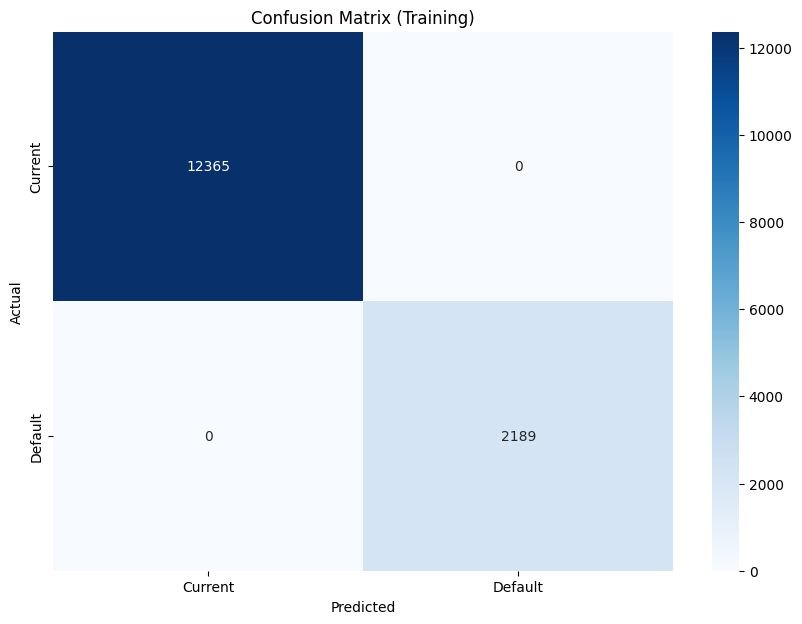

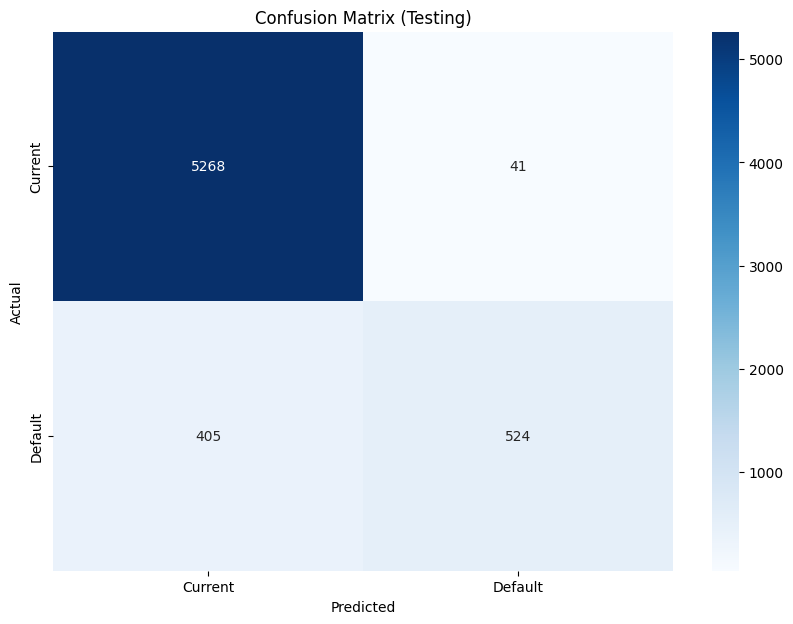

In [41]:
# Check if there are categorical columns in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Perform one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# After encoding, make sure all columns are numeric
print(X_encoded.dtypes)

# Now, split the data and fit the Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
y_train_prob = rf_model.predict_proba(X_train)[:, 1]
y_test_prob = rf_model.predict_proba(X_test)[:, 1]

# ROC AUC score
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Print AUC scores
print(f"Train ROC AUC: {train_auc}")
print(f"Test ROC AUC: {test_auc}")

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap="Blues", xticklabels=["Current", "Default"], yticklabels=["Current", "Default"])
plt.title("Confusion Matrix (Training)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap="Blues", xticklabels=["Current", "Default"], yticklabels=["Current", "Default"])
plt.title("Confusion Matrix (Testing)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
print(X_train.shape)  # Check the shape of the training data
print(X_test.shape)   # Check the shape of the test data

(14554, 158)
(6238, 158)


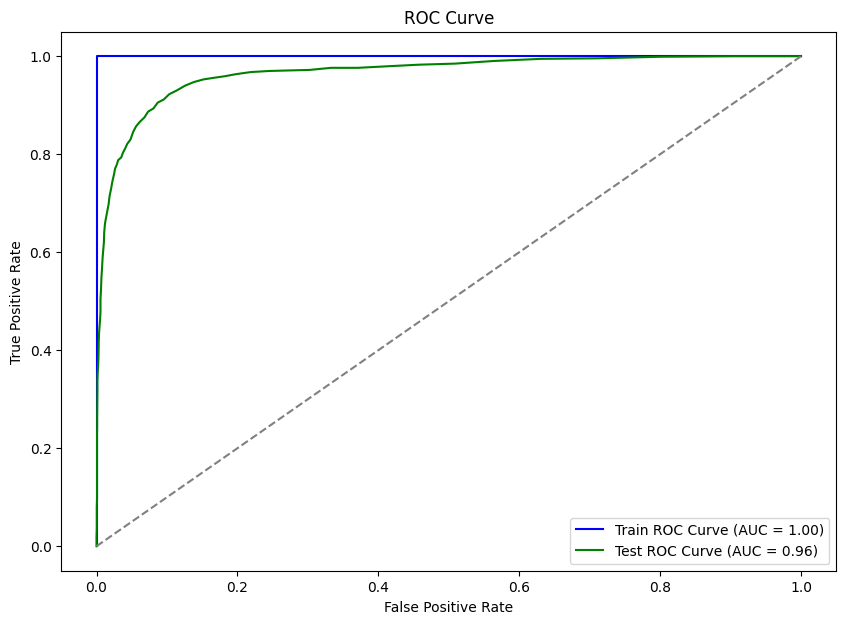

In [43]:
# ROC Curve (Plotting)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert y_train and y_test labels to numeric values (0 and 1)
y_train_encoded = label_encoder.fit_transform(y_train)  # Ensure it's in binary format
y_test_encoded = label_encoder.transform(y_test)

# Get the predicted probabilities from the RandomForest model
y_train_prob = rf_model.predict_proba(X_train)[:, 1]  # Get the probability for class 1 (binary classification)
y_test_prob = rf_model.predict_proba(X_test)[:, 1]    # Get the probability for class 1 (binary classification)

# Calculate the ROC curve for training and test sets
fpr_train, tpr_train, _ = roc_curve(y_train_encoded, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_encoded, y_test_prob)

# Calculate AUC (Area Under the Curve)
auc_train = roc_auc_score(y_train_encoded, y_train_prob)
auc_test = roc_auc_score(y_test_encoded, y_test_prob)

# Plot the ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

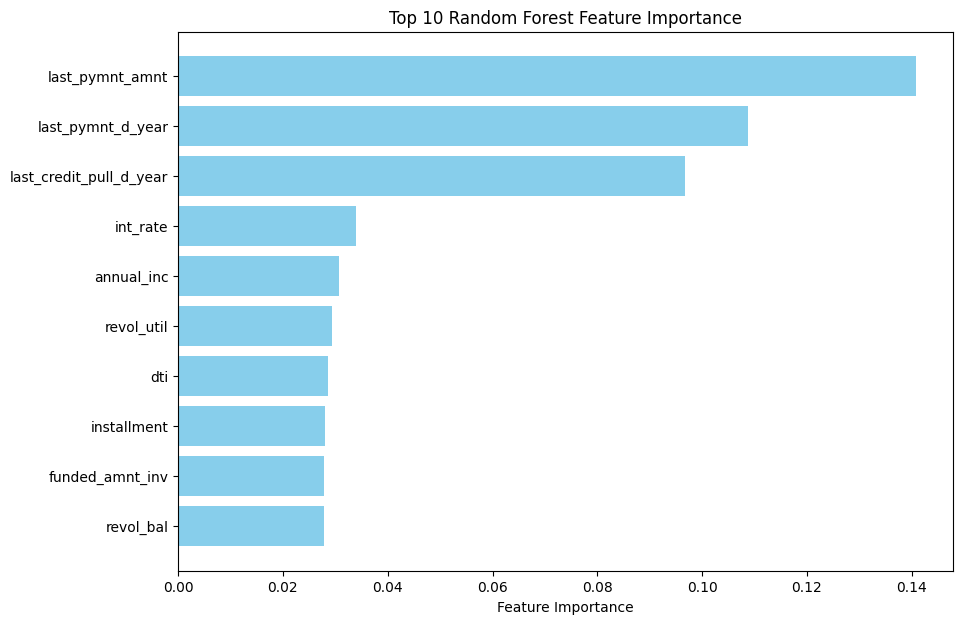

In [44]:
# Feature importances from the Random Forest model

# Ensure feature_names is derived from the DataFrame's columns if X_train is a pandas DataFrame
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns  # Get the column names directly from the DataFrame
else:
    # If X_train is not a DataFrame, create default names
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

# Feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Sorting the features by importance (in descending order)
indices = np.argsort(importances)[::-1]

# Get the top 10 feature importances
top_n = 10
top_indices = indices[:top_n]  # Get the indices of the top 10 features
top_importances = importances[top_indices]  # Get the importance values for the top 10 features
top_feature_names = np.array(feature_names)[top_indices]  # Get the feature names for the top 10 features

# Plotting the top 10 feature importances
plt.figure(figsize=(10, 7))
plt.barh(range(top_n), top_importances, align="center", color='skyblue')
plt.yticks(range(top_n), top_feature_names)  # Use actual feature names for the top 10 features
plt.xlabel('Feature Importance')
plt.title('Top 10 Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()

XGBoost Model

In [45]:
print(f"X_train_transformed shape: {X_train_transformed.shape}")
print(f"y shape: {y.shape}")

X_train_transformed shape: (14554, 21)
y shape: (20792,)


In [46]:
X.columns = X.columns.str.replace(r"[<>\[\]]", "", regex=True)
print(X.columns)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_late_fee', 'last_pymnt_amnt',
       'issue_d_year', 'earliest_cr_line_year', 'last_pymnt_d_year',
       'last_credit_pull_d_year', 'term', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'verification_status', 'purpose', 'addr_state',
       'pub_rec', 'tax_liens'],
      dtype='object')


Train ROC AUC: 0.9999895814033222
Test ROC AUC: 0.9839574165850746


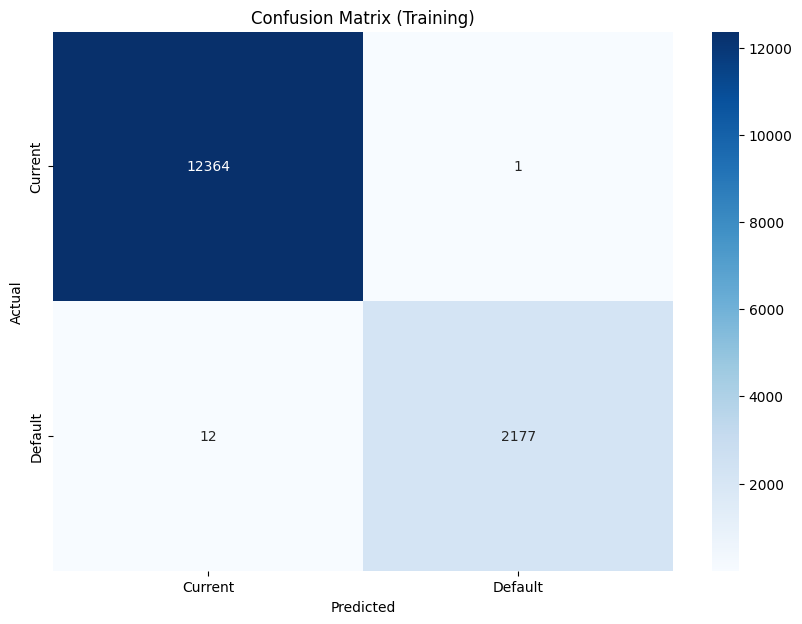

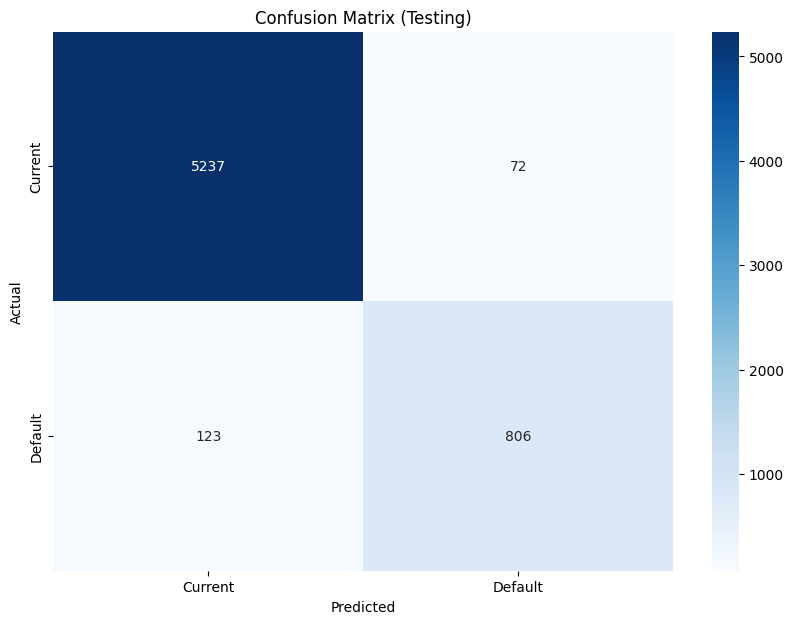

In [47]:
# Step 1: Identify categorical columns in the dataset
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Step 2: Perform one-hot encoding on categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)
X_encoded.columns = X_encoded.columns.str.replace(r'[\[\]<>]', '_', regex=True)

# Step 3: Convert string target labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Fit and transform target variable

# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 5: Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# Step 6: Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Step 7: Make predictions on both training and testing sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Step 8: Get predicted probabilities (for ROC AUC score)
y_train_prob = xgb_model.predict_proba(X_train)[:, 1]
y_test_prob = xgb_model.predict_proba(X_test)[:, 1]

# Step 9: Calculate ROC AUC scores
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Step 10: Print the ROC AUC scores
print(f"Train ROC AUC: {train_auc}")
print(f"Test ROC AUC: {test_auc}")

# Step 11: Create confusion matrices for training and testing sets
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Step 12: Plot confusion matrix for the training set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Current", "Default"], yticklabels=["Current", "Default"])
plt.title("Confusion Matrix (Training)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 13: Plot confusion matrix for the testing set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Current", "Default"], yticklabels=["Current", "Default"])
plt.title("Confusion Matrix (Testing)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

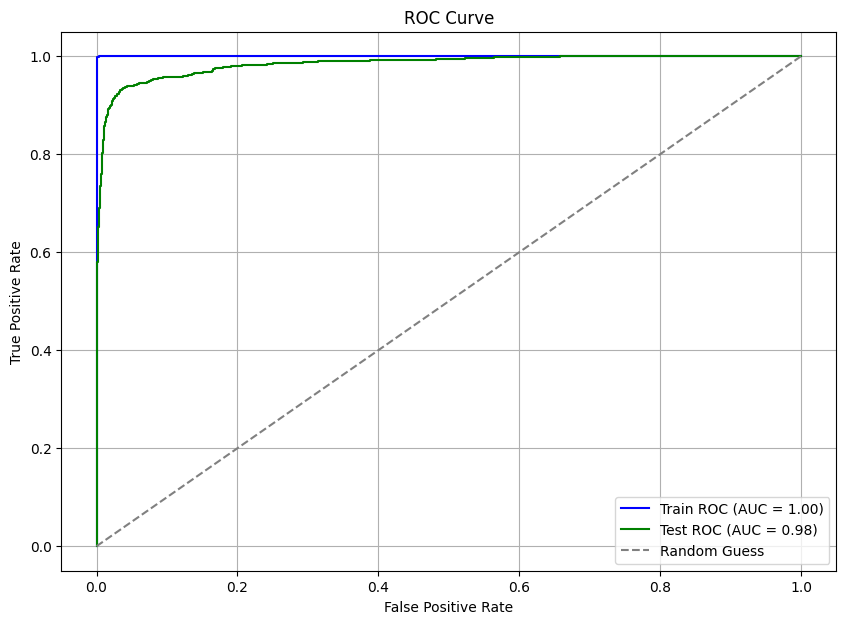

In [48]:
# ROC Curve (Plotting with AUC in legend)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')  # or 'best', 'upper left', etc.
plt.grid(True)
plt.show()

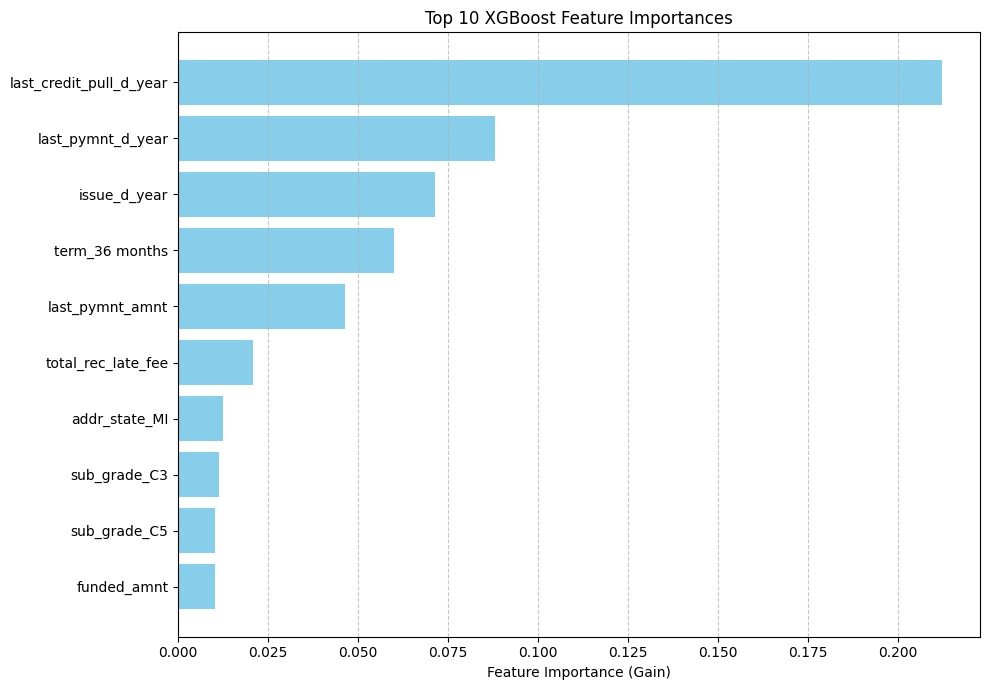

In [49]:
# Feature Importance (Variable Importance)

# Step 1: Get feature names from X_train (if it's a DataFrame)
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    # Fallback: create generic feature names if X_train is not a DataFrame
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

# Step 2: Get feature importances from the trained XGBoost model
# Default importance type is 'gain', which measures the average gain of splits which use the feature
importances = xgb_model.feature_importances_

# Step 3: Sort features by importance in descending order
indices = np.argsort(importances)[::-1]

# Step 4: Select top N features
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = np.array(feature_names)[top_indices]

# Step 5: Plotting
plt.figure(figsize=(10, 7))
plt.barh(range(top_n), top_importances, align="center", color='skyblue')
plt.yticks(range(top_n), top_feature_names)  # Show actual feature names
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 10 XGBoost Feature Importances')
plt.gca().invert_yaxis()  # Highest importance on top
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Partial Dependence Plot for XGBoost

In [50]:
print(X_train.columns.tolist())

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_late_fee', 'last_pymnt_amnt', 'issue_d_year', 'earliest_cr_line_year', 'last_pymnt_d_year', 'last_credit_pull_d_year', 'term_36 months', 'term_60 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_

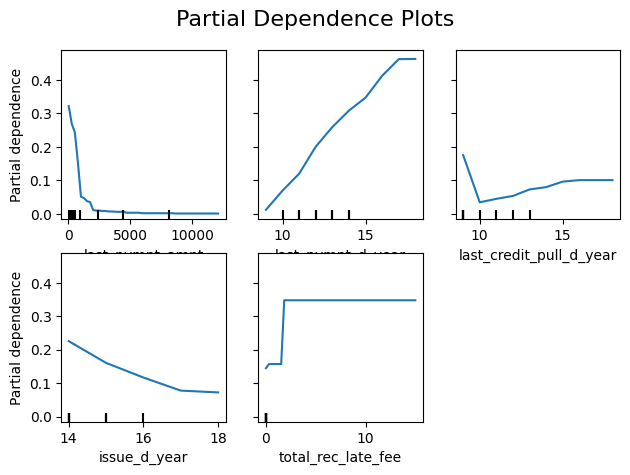

In [51]:
# Define the features you want to analyze for partial dependence
features = ['last_pymnt_amnt', 'last_pymnt_d_year', 'last_credit_pull_d_year', 'issue_d_year', 'total_rec_late_fee']

# Create Partial Dependence Plots using the from_estimator method
# This will calculate and plot the dependence of the target variable on the selected features
PartialDependenceDisplay.from_estimator(
    xgb_model,              # The trained model
    X_train,                # The training dataset (should be a DataFrame with matching feature names)
    features=features,      # Features to plot PDP for
    grid_resolution=50,     # Number of points to plot along the x-axis for each feature
    kind='average'          # Type of plot: 'average' is the default
)

# Add a title to the plot
plt.suptitle("Partial Dependence Plots", fontsize=16)
plt.tight_layout()
plt.show()

Evaluation of Precision, Recall, and F1 Score

In [52]:
# Calculate Precision, Recall, and F1 Score for Train and Test
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train Precision: {train_precision}, Test Precision: {test_precision}")
print(f"Train Recall: {train_recall}, Test Recall: {test_recall}")
print(f"Train F1 Score: {train_f1}, Test F1 Score: {test_f1}")

Train Precision: 0.9995408631772268, Test Precision: 0.9179954441913439
Train Recall: 0.9945180447693011, Test Recall: 0.8675995694294941
Train F1 Score: 0.9970231280054958, Test F1 Score: 0.8920863309352518


In [53]:
# Create a DataFrame to store the evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Train': [train_precision, train_recall, train_f1],
    'Test': [test_precision, test_recall, test_f1]
})

# Use Styler to apply formatting and styling
styled_df = metrics_df.style.format({
    'Train': '{:.4f}',   # Format Train column to 4 decimal places
    'Test': '{:.4f}'     # Format Test column to 4 decimal places
}).highlight_max(subset=['Train', 'Test'], color='lightgreen')  # Highlight the maximum value in light green
styled_df = styled_df.highlight_min(subset=['Train', 'Test'], color='salmon')  # Highlight the minimum value in light red

# Display the final styled DataFrame
styled_df

,Metric,Train,Test
0,Precision,0.9995,0.9180
1,Recall,0.9945,0.8676
2,F1 Score,0.9970,0.8921
